In [527]:
import pandas as pd
import numpy as np
# import for auto-suggestions for objects
import pydot
import pyreadline
# import for sigmoid-fct.
import scipy
import scipy.special
from scipy import stats
from scipy.stats import gamma, truncnorm, describe
import sklearn
from sklearn import preprocessing, cluster
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
# import for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time

In [653]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, multiply, dot
from keras.layers import RNN, SimpleRNN,LSTM,CuDNNLSTM, Reshape, Lambda, InputLayer, Input, BatchNormalization, Dot
from keras.layers import advanced_activations as adv_act
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import plot_model, print_summary
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import seaborn as sb
import sobol_seq

# Function and Class Setup

In [4]:
def get_termlife_annuity(age, duration, interest, A= 0.00022, B=2.7*10**(-6), c=1.124):
    
    v = 1/(1+interest)
    ann = 0
    for k in range(duration):
        ann+= v**k*np.exp(-A*k-B/np.log(c)*c**(age)*(c**k-1))                  
    
    return ann

In [5]:
def get_termlife_APV_ben(age, duration, interest, A= 0.00022, B=2.7*10**(-6), c=1.124):
    
    v = 1/(1+interest)
    apv = 0
    for k in range(duration):
        apv += v**(k+1)*np.exp(-A*k-B/np.log(c)*c**(age)*(c**k-1))*(1-np.exp(-A-B/np.log(c)*c**(age+k)*(c-1)))
    
    return apv

In [6]:
def get_termlife_premium(age_init,Sum_ins,duration,  interest,  A= 0.00022, B=2.7*10**(-6), c=1.124):
    
    return Sum_ins*get_termlife_APV_ben(age_init, duration, interest, A, B, c)/get_termlife_annuity(age_init, duration, interest, A, B, c)

In [7]:
def get_termlife_reserve(age_curr, Sum_ins, duration,  interest,age_of_contract=0, A= 0.00022, B=2.7*10**(-6), c=1.124):
    age_init = age_curr-age_of_contract
    prem = get_termlife_premium(age_init,Sum_ins, duration, interest, A,B,c)
    apv_prem = get_termlife_annuity(age_curr, duration-age_of_contract, interest, A,B,c)
    apv_ben = get_termlife_APV_ben(age_curr, duration-age_of_contract, interest, A,B,c)
    
    return Sum_ins*apv_ben -prem*apv_prem 

In [8]:
def get_termlife_reserve_profile(age_curr, Sum_ins, duration, interest,age_of_contract = 0,  A= 0.00022, B=2.7*10**(-6), c=1.124, option_past = True):
    
    age_init = age_curr-age_of_contract
    premium = get_termlife_premium(age_init, Sum_ins,duration, interest, A,B,c)
    reserve = np.zeros(duration+1)
    
    # No expenses so far
    e_ann = 0
    e_init = 0
    # No claims-related expenses
    E_claim = 0
    reserve[0] = - e_init
    reserve[-1] = 0
    for k in range(duration-1): # Exclude value of reserve at maturity of contract (set 0, to avoid inaccuracy due to rounding errors)
        prob_live = np.exp(-A-B/np.log(c)*c**(age_init+k)*(c-1))# at age x+k
        reserve[k+1] =((reserve[k]+premium-e_ann)*(1+interest) - (Sum_ins+E_claim)*(1-prob_live))/prob_live
        pass
    
    
    if option_past==False:
        reserve = reserve[age_of_contract:]

    return reserve   

In [9]:
t_start = time.time()

# Premium Calculation for a RLV contract

def getPremium(age, w, duration, A, B, c, Sum_ins,v):
        
    # Note: Age in the following not yet considered    
    prob_live_k = 1
    term_live = 0
    annuity = 0
    for k in range(duration):
        # 1-year Survival probability at age k for the Standard Ultimate Survival Model
        # This is based on Makeham's law
        if age+k>= w:
            prob_live_k = 0
        else:
            prob_live_k = np.exp(-A*k-B/np.log(c)*c**age*(c**k-1)) 
        
        annuity = annuity + v**k*prob_live_k
        term_live = term_live+v**(k+1)*prob_live_k*(1-np.exp(-A-B/np.log(c)*c**(age+k)*(c-1)))
        
        # Use iterative (invers) formula to obtain annuity
        # annuity = 1 + v*prob_live_k*annuity # whole life annuity
        # endowment = v*(1-prob_live_k)+v*prob_live_k*endowment # whole life endowment
        pass
    
    # Formula flawed ?!?!?!
    # term_live = 1-(1-v)*annuity - v**duration*np.exp(-A*duration-B/np.log(c)*c**age*(c**duration-1))  # subtracting endowment insurance part

    # Calculate Premium with Equivalence Principle
    # expenses, can be included in fct setup
    E_ins = 0
    E_init = 0
    E_ann = 0
    P = (term_live*(Sum_ins+E_ins)-E_init)/annuity - E_ann
    return P #, annuity, term_live
    pass

In [10]:
def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

In [11]:
class RLV:
    
    def __init__(self, age_init,  duration, Sum_insured, interest_rate,age_of_contract = 0,A= 0.00022, B=2.7*10**(-6), c=1.124,age_max = 131,Premium_frequency='annually', sex='male'):
        self.age_init = age_init
        self.sex = sex
        self.age_max = age_max
        #self.t = time_elapsed # Include time since contract was signed
        self.duration = duration
        
        # Parameters for Makeham mortality model
        self.A = A
        self.B = B
        self.c = c

        self.Sum_ins = Sum_insured # Potentially as vector to represent change over time
        self.Premium_freq = Premium_frequency # Not used so far, i.e. set annually
        self.interest_rate = interest_rate
        self.v = 1/(1+interest_rate)
        self.Premium = getPremium(self.age_init, self.age_max, self.duration, self.A, self.B, self.c, self.Sum_ins,self.v)
        pass
    
    def reserve(self):
        # (t+1)_V_k = (t_V_x +P_t-e_t)*(1+i) -(Sum_ins + E_(t+1))*q_(x+k)//(1 - q_(x+t))
        
        
        res = np.zeros(self.duration+1)
        # No expenses so far
        e_ann = 0
        e_init = 0
        # No claims-related expenses
        E_claim = 0
        res[0] = - e_init
        for k in range(self.duration):
            prob_live = np.exp(-self.A-self.B/np.log(self.c)*self.c**(self.age_init+k)*(self.c-1))# at age x+k
            res[k+1] =((res[k]+self.Premium-e_ann)*(1+self.interest_rate) - (self.Sum_ins+E_claim)*(1-prob_live))/prob_live
            pass
        
        return res
    
    pass

In [12]:
### Function to evaluate reserve profile of multiple contracts

def reserve_calc(age_start, Sum_ins, duration, interest_rate,age_of_contract = 0, A= 0.00022, B=2.7*10**(-6), c=1.124 ):
    
    if(age_start.shape==()):
        return 'This method is not intended for only one record.'
    n = len(age_start)
    if n != len(Sum_ins) or n != len(duration):
        print('Invalid input! Input vectors must be of equal length.')
        return 
    
    if type(age_of_contract) == int and n > 1:
        age_of_contract = np.zeros(len(age_start)).astype(int)


    max_dur = max(duration)
    max_aoc = 0
    if len(age_of_contract) != 0:
        max_aoc = max(age_of_contract)
        
    reserve = np.zeros(max_aoc+ max(max(duration-age_of_contract),0) +1)## to be adapted for contracts which were signed in the past
      
    targets = np.zeros([n,max_aoc+ max(max(duration-age_of_contract),0) +1])
        
    for i in range(n):

        cache = RLV(age_start[i],duration[i],  Sum_ins[i],interest_rate).reserve()
        targets[i,max_aoc-age_of_contract[i]:max_aoc-age_of_contract[i]+(duration[i]+1)] = cache
        #reserve[max_aoc-age_of_contract[i]:max_aoc-age_of_contract[i]+(duration[i]+1)] = reserve[max_aoc-age_of_contract[i]:max_aoc-age_of_contract[i]+(duration[i]+1)] + cache
        pass
    
    return targets #reserve,

In [13]:
print(np.exp(-0.00022*27-2.7*10**(-6)/np.log(1.124)*1.124**40*(1.124**27-1)))
get_termlife_premium(40, 100000,27,0.05,0.00022, 2.7*10**(-6), 1.124)
#type(data[:,1])== np.ndarray

0.9402022498400525


161.7203636462508

In [14]:
test = get_termlife_reserve_profile(age_curr=50, Sum_ins=100000, duration=27, interest = 0.05, age_of_contract=10, option_past=  False)
test

array([1205.71625913, 1316.54679006, 1420.96790228, 1517.17843876,
       1603.10013108, 1676.33882384, 1734.14005671, 1773.33806885,
       1790.29710443, 1780.84366764, 1740.18808916, 1662.83340847,
       1542.46912672, 1371.84681826, 1142.63386918,  845.24069399,
        468.61560581,    0.        ])

In [15]:
#test = RLV(age_init = 40,duration = 27,  Sum_insured =100000, age_of_contract=10,interest_rate= 0.05) #,A= 0.00022, B=2.7*10**(-6), c=1.124,)
#print(test.Premium)
#test.reserve().max()

Text(0.05, -0.1, 'Feature Variables: Age 40 (yrs), Sum insured 100000€, Duration 20 (yrs), \n Age of Contract 10 (yrs) interest rate 5%')

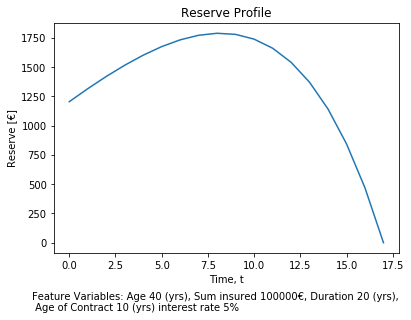

In [16]:
fig = plt.figure()
ax = fig.add_axes([.1,.1,.8,.8])
ax.plot(test)
ax.set_xlabel('Time, t')
ax.set_ylabel('Reserve [€]')
ax.set_title('Reserve Profile')
fig.text(0.05, -.1,'Feature Variables: Age 40 (yrs), Sum insured 100000€, Duration 20 (yrs), \n Age of Contract 10 (yrs) interest rate 5%')


Text(0.5, 1.0, 'One Year Death Probabilites based on the SUSM')

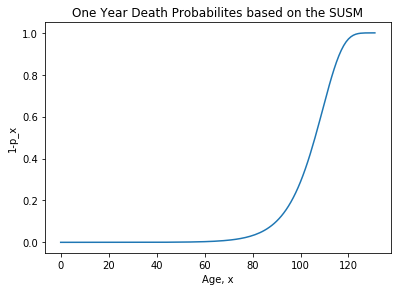

In [17]:
A= 0.00022
B=2.7*10**(-6)
c=1.124
time_range = np.linspace(0,131,132)
fig = plt.figure()
ax = fig.add_axes([.1,.1,.8,.8])
ax.plot(1-np.exp(-A-B/np.log(c)*c**time_range*(c**1-1)))
ax.set_xlabel('Age, x')
ax.set_ylabel('1-p_x')
ax.set_title('One Year Death Probabilites based on the SUSM')
#fig.text(0.05, -.05,'Feature Variables: Age 40 (yrs), Duration 20 (yrs), Sum insured 100000€, interest rate 5%')


# Data Simulation, Part I

In [377]:
#### Basic Parameters for Empirical Analysis ####

# Makeham mortality model
A= 0.00022
B=2.7*10**(-6)
c=1.124
age_max = 131

# Gender
# All individuals are male
# Note: For female adapted mortality parameters are required
# This could be implemented using a case switch

# current directory for saving issues
cd = r"C:\Users\mark.kiermayer\Documents\Python Scripts\Master Thesis - Code"

In [19]:
##### Simulate Data for Reserve Calculation#####

N_contracts = 100000 # adjustable
int_rate = 0.05 # fixed for now
input_used = ['age_start', 'Sum_ins', 'duration', 'age_of_contract'] # input parameters
n_in = len(input_used)
data = np.zeros([N_contracts,n_in])
Max_min = np.zeros([n_in,2])
age_low = 18
age_up = 67
Sum_min = 1000
Sum_max = 1000000
dur_min = 2
dur_max = 40
aoc_min = 0
aoc_max = dur_max-1

# Matrix Version of previous upper/ lower bounds on features
Max_min[0,0] = age_low
Max_min[0,1] = age_up
Max_min[1,0] = Sum_min
Max_min[1,1] = Sum_max
Max_min[2,0] = dur_min
Max_min[2,1] = dur_max
Max_min[3,0] = aoc_min
Max_min[3,1] = aoc_max

# Standard values of features for projections
age_std = 40
Sum_std = 100000
dur_std = 20
aoc_std = 0


# Use Sobol Sequence to optimize uniform coverage of multidimensional feature space
random.seed(42)
data[:,0:-1] = sobol_seq.i4_sobol_generate(n_in-1,N_contracts) # simulate age_of_contract seperately, conditionally on the duration

# Simulate ages of contract holders
data[:,0] =(age_low + (age_up-age_low)*data[:,0])

# simulate sums insured
data[:,1] = (Sum_min+(Sum_max-Sum_min)*data[:,1])

# simulate duration
data[:,2] = (dur_min+(dur_max-dur_min)*data[:,2])

# simulate age of contract, i.e. introduce shifts in reserve profiles
rnd = np.random.rand(N_contracts)
data[:,3] = rnd*(data[:,2]-1) # random percentage of duration has passed; at least one remaining year of contract (hence dur - 1)

# ceil data as integers
data = data.astype('int')

In [20]:
sum(data[:,2]==data[:,3])

3807

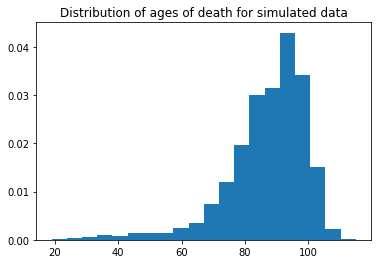

In [21]:
# simulate years of death
deaths = np.random.rand(N_contracts)
age_at_death = np.random.rand(N_contracts)
cum_probs_live = np.zeros([age_up-age_low+1,age_max-age_low])
range_age = np.array(range(age_low, age_up),ndmin = 2).T
range_time = np.array(range(age_max-age_low),ndmin= 2)
cum_probs_live = np.array(np.exp(-np.dot(A,range_time)-B/np.log(c)*c**range_age*(c**(range_time)-1)),ndmin = 2)

for k in range(N_contracts):
    age_at_death[k] = (np.where(cum_probs_live[(data[k,0].astype(int)-age_low-1),:]<deaths[k]))[0][0]
    pass

# add age at entry and years of survival to obtain age of deatch
age_at_death = age_at_death+data[:,0]

plt.hist(age_at_death,bins=20,density=1)
plt.title('Distribution of ages of death for simulated data')
plt.show()

In [22]:
### Lower-dimensional Datasets

# 1-dim: Solely Age Variable (input_used = ['age_start', 'Sum_ins', 'duration', 'age_of_contract'])
data_age = data[:,0]
data_sum = data[:,1]
data_dur = data[:,2]
data_aoc = data[:,3]
N_contracts

100000

## Calculate Target Values

In [23]:
# For high-dim. dataset (without any projections)
#targets = reserve_calc(age_start= data[:,0], Sum_ins = data[:,1], duration = data[:,2], interest_rate= int_rate, age_of_contract = data[:,3])
targets = np.zeros([N_contracts,dur_max +1] ) #max_aoc+ max(max(duration-age_of_contract),0) +1
for i in range(N_contracts):
    #targets[i,aoc_max-data[i,3]:aoc_max-data[i,3]+(data[i,2]+1)] = get_termlife_reserve_profile(age_curr = data[i,0], Sum_ins = data[i,1],duration= data[i,2],  interest = 0.05, age_of_contract = data[i,3])
    targets[i,0:max(data[i,2]-data[i,3]+1,0)] = get_termlife_reserve_profile(age_curr = data[i,0], Sum_ins = data[i,1],duration= data[i,2],  interest = int_rate, age_of_contract = data[i,3], option_past=False)

In [24]:
targets[0,:], data[0,:], len(targets[0,:]), dur_max, aoc_max
(targets == 0).sum(axis= 0)/N_contracts

array([0.11655, 0.11724, 0.19577, 0.26294, 0.32379, 0.37855, 0.42794,
       0.47379, 0.5162 , 0.55562, 0.59151, 0.62524, 0.65756, 0.6874 ,
       0.71495, 0.74141, 0.76471, 0.78705, 0.8084 , 0.82809, 0.84652,
       0.86382, 0.88   , 0.89461, 0.90738, 0.92039, 0.93201, 0.94237,
       0.95192, 0.9604 , 0.96773, 0.97452, 0.97994, 0.98503, 0.98942,
       0.99286, 0.99591, 0.99802, 0.99934, 1.     , 1.     ])

In [25]:
# For projected data sets
#targets_age= reserve_calc(age_start= data_age, Sum_ins = np.repeat(Sum_std,N_contracts), duration = np.repeat(dur_std,N_contracts), interest_rate= int_rate, age_of_contract = np.repeat(aoc_std,N_contracts))
#targets_sum= reserve_calc(age_start= np.repeat(age_std,N_contracts), Sum_ins = data_sum, duration = np.repeat(dur_std,N_contracts), interest_rate= int_rate, age_of_contract = np.repeat(aoc_std,N_contracts))
#targets_dur= reserve_calc(age_start= np.repeat(age_std,N_contracts), Sum_ins = np.repeat(Sum_std,N_contracts), duration = data_dur, interest_rate= int_rate, age_of_contract = np.repeat(aoc_std,N_contracts))
#targets_aoc= reserve_calc(age_start= np.repeat(age_std,N_contracts), Sum_ins = np.repeat(Sum_std,N_contracts), duration = np.repeat(dur_std,N_contracts), interest_rate= int_rate, age_of_contract = data_aoc)

# For projected data sets
targets_age, targets_sum, targets_dur, targets_aoc = np.zeros([N_contracts,dur_std+1]), np.zeros([N_contracts,dur_std+1]),np.zeros([N_contracts,dur_max+1]),np.zeros([N_contracts,dur_std+1])

for i in range(N_contracts):
    targets_age[i,:] = get_termlife_reserve_profile(age_curr= data_age[i], Sum_ins = Sum_std, duration = dur_std, age_of_contract = aoc_std,interest= int_rate,option_past=False)
#for i in range(len(data_sum)):    
    targets_sum[i,:] = get_termlife_reserve_profile(age_curr= age_std, Sum_ins = data_sum[i], duration = dur_std,  age_of_contract = aoc_std,interest= int_rate,option_past=False)
#for i in range(len(data_dur)):    
    targets_dur[i,0:(data_dur[i]+1)] = get_termlife_reserve_profile(age_curr= age_std, Sum_ins = Sum_std, duration = data_dur[i], age_of_contract = aoc_std, interest= int_rate,option_past=False)
#for i in range(len(data_aoc)):    
    targets_aoc[i,0:max(dur_std-data_aoc[i]+1,0)] = get_termlife_reserve_profile(age_curr= age_std, Sum_ins = Sum_std, duration = dur_std, age_of_contract = data_aoc[i], interest= int_rate,option_past=False)

In [26]:
targets_aoc[70,:], int_rate

(array([177.48895332, 209.50914294, 239.34601427, 266.42010087,
        290.0642211 , 309.5116298 , 323.88259081, 332.16915038,
        333.21785705, 325.71013363, 308.13995927, 278.78846267,
        235.69496004, 176.62388955,  99.02699598,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ]), 0.05)

## Data Preparation, i.e. Scaling and Splitting (Training vs Test Data)

In [27]:
#### Scale feature components to [-1,+1]
data_sc = 2*(data- Max_min[:,0])/(Max_min[:,1]-Max_min[:,0]) -1
data_age_sc = data_sc[:,0]
data_sum_sc = data_sc[:,1]
data_dur_sc = data_sc[:,2]
data_aoc_sc = data_sc[:,3]

In [28]:
targets[10,:]

array([ 0.        , 29.74542579, 41.90722401, 33.23054517,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [29]:
### Scale targets (reserve values) based on max reserve
# Step 1: Find max and min
V_max = get_termlife_reserve_profile(age_curr=age_up, Sum_ins = Sum_max, duration=dur_max, interest = int_rate).max()
V_min = get_termlife_reserve_profile(age_curr=age_low, Sum_ins = Sum_min, duration=dur_min, interest = int_rate).min()
#V_max, V_min

V_age_max = get_termlife_reserve_profile(age_curr=age_up, Sum_ins = Sum_std, duration=dur_std, interest = int_rate).max()
V_age_min = get_termlife_reserve_profile(age_curr=age_low, Sum_ins = Sum_std, duration=dur_std, interest = int_rate).min()
V_sum_max = get_termlife_reserve_profile(age_curr=age_std, Sum_ins = Sum_max, duration=dur_std, interest = int_rate).max()
V_sum_min = get_termlife_reserve_profile(age_curr=age_std, Sum_ins = Sum_min, duration=dur_std, interest = int_rate).min()
V_dur_max = get_termlife_reserve_profile(age_curr=age_std, Sum_ins = Sum_std, duration=dur_max, interest = int_rate).max()
V_dur_min = get_termlife_reserve_profile(age_curr=age_std, Sum_ins = Sum_std, duration=dur_min, interest = int_rate).min()
V_aoc_max = get_termlife_reserve_profile(age_curr=age_std, Sum_ins = Sum_std, duration=dur_std, interest = int_rate).max()
V_aoc_min = get_termlife_reserve_profile(age_curr=age_std, Sum_ins = Sum_std, duration=dur_std, interest = int_rate).min()

In [30]:
V_sum_max, targets_sum.argmax(axis=0), targets_sum[65536,:], data_sum[65536,], get_termlife_reserve_profile(age_curr=age_std, Sum_ins = 999992, duration=dur_std, interest = 0.05)

(5966.637832085928,
 array([    0, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536,
        65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536, 65536,
        65536, 65536,     0], dtype=int64),
 array([   0.        ,  655.61308659, 1306.30819663, 1947.1706574 ,
        2572.46059604, 3175.4987546 , 3748.53707506, 4282.61194875,
        4767.37770271, 5190.91751563, 5539.52850609, 5797.47720094,
        5946.72095163, 5966.59009898, 5833.42475978, 5520.15898546,
        4995.84367451, 4225.09794437, 3167.47660698, 1776.73884277,
           0.        ]),
 999992,
 array([   0.        ,  655.61308659, 1306.30819663, 1947.1706574 ,
        2572.46059604, 3175.4987546 , 3748.53707506, 4282.61194875,
        4767.37770271, 5190.91751563, 5539.52850609, 5797.47720094,
        5946.72095163, 5966.59009898, 5833.42475978, 5520.15898546,
        4995.84367451, 4225.09794437, 3167.47660698, 1776.73884277,
           0.        ]))

In [31]:
#V_max, V_age_max, V_sum_max, V_dur_max, V_aoc_max

targets_sc = 2*(targets-0)/(V_max-0)-1
targets_log_sc = 2*(np.log(1+targets)-0)/(np.log(1+V_max)-0)-1
targets_age_sc = 2*(targets_age-0)/(V_age_max-0)-1
targets_sum_sc = 2*(targets_sum-0)/(V_sum_max-0)-1
targets_dur_sc = 2*(targets_dur-0)/(V_dur_max-0)-1
targets_aoc_sc = 2*(targets_aoc-0)/(V_aoc_max-0)-1

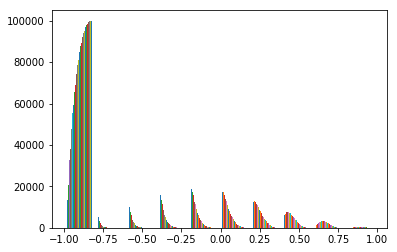

In [32]:
plt.hist(targets_log_sc)
plt.show()

In [33]:
#### Split (raw and scaled) Data in Training and Test Set ####

ratio_tr_tst = 0.7
N_train = int(ratio_tr_tst*N_contracts)

### Complete Data
data_train,data_train_sc = data[0:N_train,],data_sc[0:N_train,]
data_test, data_test_sc = data[N_train:,], data_sc[N_train:,]
targets_train, targets_test= targets[0:N_train,], targets[N_train:,]
targets_test_cum, targets_train_cum = targets_test.sum(axis = 0), targets_train.sum(axis = 0)


### Projected Data
# Age
data_age_train,data_age_train_sc = data_age[0:N_train],data_age_sc[0:N_train]
data_age_test, data_age_test_sc = data_age[N_train:], data_age_sc[N_train:]
targets_age_train, targets_age_test= targets_age[0:N_train,], targets_age[N_train:,]
targets_age_train_sc, targets_age_test_sc= targets_age_sc[0:N_train,], targets_age_sc[N_train:,]
targets_age_test_cum, targets_age_train_cum = targets_age_test.sum(axis = 0), targets_age_train.sum(axis = 0)

# Sum insured
data_sum_train,data_sum_train_sc = data_sum[0:N_train],data_sum_sc[0:N_train]
data_sum_test, data_sum_test_sc = data_sum[N_train:], data_sum_sc[N_train:]
targets_sum_train, targets_sum_test= targets_sum[0:N_train,], targets_sum[N_train:,]
targets_sum_train_sc, targets_sum_test_sc= targets_sum_sc[0:N_train,], targets_sum_sc[N_train:,]
targets_sum_test_cum, targets_sum_train_cum = targets_sum_test.sum(axis = 0), targets_sum_train.sum(axis = 0)

# Duration
data_dur_train,data_dur_train_sc = data_dur[0:N_train],data_dur_sc[0:N_train]
data_dur_test, data_dur_test_sc = data_dur[N_train:], data_dur_sc[N_train:]
targets_dur_train, targets_dur_test= targets_dur[0:N_train,], targets_dur[N_train:,]
targets_dur_train_sc, targets_dur_test_sc= targets_dur_sc[0:N_train,], targets_dur_sc[N_train:,]
targets_dur_test_cum, targets_dur_train_cum = targets_dur_test.sum(axis = 0), targets_dur_train.sum(axis = 0)

# Age of Contract
data_aoc_train,data_aoc_train_sc = data_aoc[0:N_train],data_aoc_sc[0:N_train]
data_aoc_test, data_aoc_test_sc = data_aoc[N_train:], data_aoc_sc[N_train:]
targets_aoc_train, targets_aoc_test= targets_aoc[0:N_train,], targets_aoc[N_train:,]
targets_aoc_train_sc, targets_aoc_test_sc= targets_aoc_sc[0:N_train,], targets_aoc_sc[N_train:,]
targets_aoc_test_cum, targets_aoc_train_cum = targets_aoc_test.sum(axis = 0), targets_aoc_train.sum(axis = 0)

# Part I: Reserve Replication, Single Contract Basis

## Preliminary Analysis: Convergence Rates for 1-dimensional Projections of Feature Space

In [34]:
# Common parameters of following models
act1, act2 = 'relu', 'linear'
opt, loss_type, metrics_type = 'adam', 'mse', 'mae'
N_epochs = 600
val_share = 0.25
chkp_freq = 25 # checkpoint every 25 epochs

In [34]:
## Models, set ups


# Age
n_age_out = targets_age.shape[1] # length of output
filepath_age="w-age-dev-{epoch:03d}.hdf5"
checkpoint = ModelCheckpoint(filepath_age, monitor='mae', verbose=0, save_best_only=False, period = chkp_freq )
callbacks_list_age = [checkpoint]
model_age = Sequential()
model_age.add(Dense(units = 3*n_age_out, activation = act1,input_dim = 1 ))
model_age.add(Dense(units = n_age_out, activation = act2))
model_age.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])
w_init_age = model_age.get_weights()

model_age_1out = Sequential()
filepath_age_1out="w-age_1out-dev-{epoch:03d}.hdf5"
checkpoint = ModelCheckpoint(filepath_age_1out, monitor='mae', verbose=0, save_best_only=False, period = chkp_freq)
callbacks_list_age_1out = [checkpoint]
model_age_1out.add(Dense(units = 3*n_age_out, activation = act1,input_dim = 1 ))
model_age_1out.add(Dense(units = 1, activation = act2))
model_age_1out.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])


# Sum ins
n_sum_out = targets_sum.shape[1] # length of output
model_sum = Sequential()
model_sum.add(Dense(units = 3*n_sum_out, activation = act1,input_dim = 1 ))
model_sum.add(Dense(units = n_sum_out, activation = act2))
model_sum.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])

# Duration
n_dur_out = targets_dur.shape[1] # length of output
model_dur = Sequential()
model_dur.add(Dense(units = 3*n_dur_out, activation = act1,input_dim = 1 ))
model_dur.add(Dense(units = n_dur_out, activation = act2))
model_dur.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])

# Age of Contract
n_aoc_out = targets_aoc.shape[1] # length of output
model_aoc = Sequential()
model_aoc.add(Dense(units = 3*n_aoc_out, activation = act1,input_dim = 1 ))
model_aoc.add(Dense(units = n_aoc_out, activation = act2))
model_aoc.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])

Instructions for updating:
Colocations handled automatically by placer.


In [35]:
targets_age_train

array([[   0.        ,   82.69103894,  164.76246075, ...,  400.08406414,
         224.48329496,    0.        ],
       [   0.        ,  328.11176083,  653.80008194, ..., 1621.25165538,
         913.45282003,    0.        ],
       [   0.        ,   20.45914668,   40.7643732 , ...,   98.47110478,
          55.19479607,    0.        ],
       ...,
       [   0.        ,  147.41113855,  293.72214041, ...,  717.14082826,
         402.81362785,    0.        ],
       [   0.        ,    9.03653839,   18.00504116, ...,   43.45186083,
          24.35100476,    0.        ],
       [   0.        ,    7.15398937,   14.25411003, ...,   34.3942807 ,
          19.27442517,    0.        ]])

In [36]:
time_dim1 = time.time()

## Train Models
hist_age = model_age.fit(data_age_train, targets_age_train,batch_size=100,epochs = N_epochs,callbacks=callbacks_list_age, validation_split= val_share,verbose = 0)
hist_sum = model_sum.fit(data_sum_train, targets_sum_train,batch_size=100,epochs = N_epochs, validation_split= val_share,verbose = 0)
hist_dur = model_dur.fit(data_dur_train, targets_dur_train,batch_size=100,epochs = N_epochs, validation_split= val_share,verbose = 0)
hist_aoc = model_aoc.fit(data_aoc_train, targets_aoc_train,batch_size=100,epochs = N_epochs, validation_split= val_share,verbose = 0)

time2_dim1 = time.time()

w_age_final = model_age.get_weights()
w_age_1out_final = model_age_1out.get_weights()

Instructions for updating:
Use tf.cast instead.


#### Plots of Convergence Rates

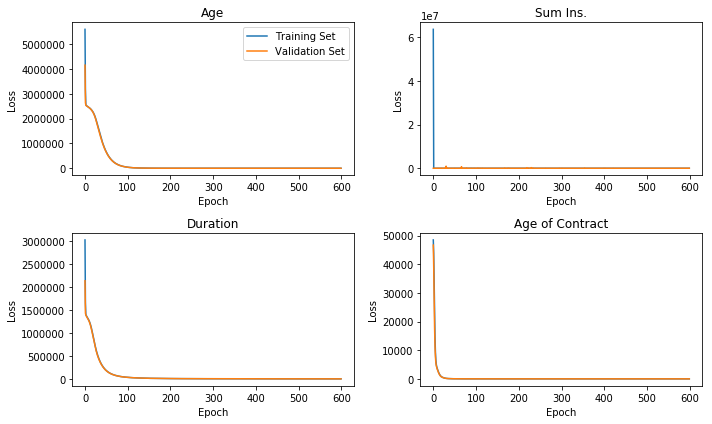

In [37]:
plt.figure(1, figsize = (10,6))
plt.subplot(221)
plt.plot(hist_age.history['loss'])
plt.plot(hist_age.history['val_loss'])
plt.title('Age')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper right')

plt.subplot(222)
plt.plot(hist_sum.history['loss'])
plt.plot(hist_sum.history['val_loss'])
plt.title('Sum Ins.')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['Training Set', 'Validation Set'], loc='upper right')

plt.subplot(223)
plt.plot(hist_dur.history['loss'])
plt.plot(hist_dur.history['val_loss'])
plt.title('Duration')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['Training Set', 'Validation Set'], loc='upper right')

plt.subplot(224)
plt.plot(hist_aoc.history['loss'])
plt.plot(hist_aoc.history['val_loss'])
plt.title('Age of Contract')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['Training Set', 'Validation Set'], loc='upper right')

plt.tight_layout()

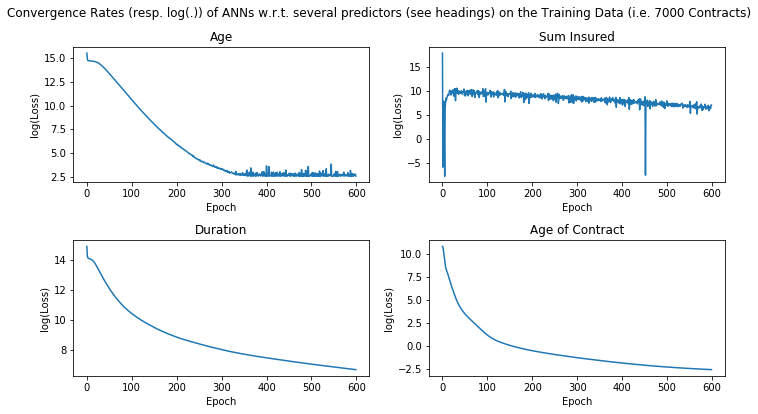

In [38]:
fig, axis = plt.subplots(2,2, figsize = (10,6))
fig. suptitle('Convergence Rates (resp. log(.)) of ANNs w.r.t. several predictors (see headings) on the Training Data (i.e. 7000 Contracts)')
axis[0][0].plot(np.log(hist_age.history['loss']))
axis[0][0].set_title('Age')
axis[0][0].set_xlabel('Epoch')
axis[0][0].set_ylabel('log(Loss)')
axis[0][1].plot(np.log(hist_sum.history['loss']))
axis[0][1].set_title('Sum Insured')
axis[0][1].set_xlabel('Epoch')
axis[0][1].set_ylabel('log(Loss)')
axis[1][0].plot(np.log(hist_dur.history['loss']))
axis[1][0].set_title('Duration')
axis[1][0].set_xlabel('Epoch')
axis[1][0].set_ylabel('log(Loss)')
axis[1][1].plot(np.log(hist_aoc.history['loss']))
axis[1][1].set_title('Age of Contract')
axis[1][1].set_xlabel('Epoch')
axis[1][1].set_ylabel('log(Loss)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [39]:
print((hist_age.history['mean_absolute_error'][-1]))
print((np.abs(model_age.predict(data_age_train)-targets_age_train)).mean(axis=1).mean())

print((hist_age.history['loss'][-1]))
print(((model_age.predict(data_age_train)-targets_age_train)**2).mean(axis=1).mean())
targets_age_train.mean().mean()

2.1256558345613024
2.0409123905020756
13.116888767424085
12.85507624978213


1340.20445996145

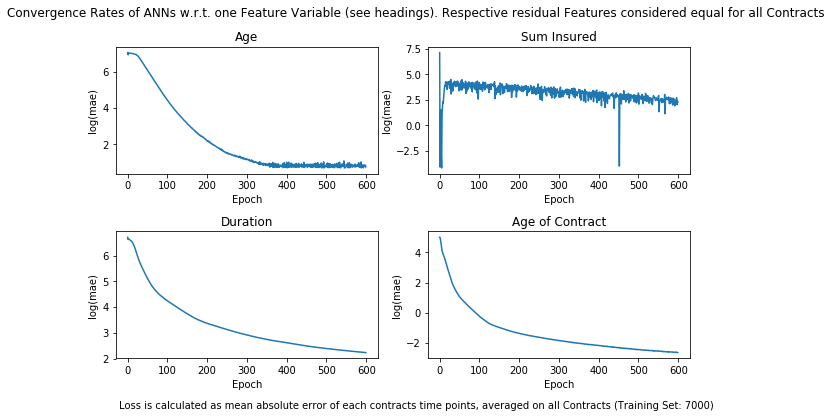

In [40]:
fig, axis = plt.subplots(2,2, figsize = (10,6))
fig. suptitle('Convergence Rates of ANNs w.r.t. one Feature Variable (see headings). Respective residual Features considered equal for all Contracts')
axis[0][0].plot(np.log(hist_age.history['mean_absolute_error']))
axis[0][0].set_title('Age')
axis[0][0].set_xlabel('Epoch')
axis[0][0].set_ylabel('log(mae)')
axis[0][1].plot(np.log(hist_sum.history['mean_absolute_error']))
axis[0][1].set_title('Sum Insured')
axis[0][1].set_xlabel('Epoch')
axis[0][1].set_ylabel('log(mae)')
axis[1][0].plot(np.log(hist_dur.history['mean_absolute_error']))
axis[1][0].set_title('Duration')
axis[1][0].set_xlabel('Epoch')
axis[1][0].set_ylabel('log(mae)')
axis[1][1].plot(np.log(hist_aoc.history['mean_absolute_error']))
axis[1][1].set_title('Age of Contract')
axis[1][1].set_xlabel('Epoch')
axis[1][1].set_ylabel('log(mae)')

fig.text(.5, .05, 'Loss is calculated as mean absolute error of each contracts time points, averaged on all Contracts (Training Set: 7000)', ha='center')

plt.tight_layout(rect=[0.03, 0.07, 0.9, 0.95])

In [41]:
#hist_age.history['mean_absolute_error'][-1]
#age_pred-targets_age_test

### Visual Quality of Prediction

C:\Users\mark.kiermayer\Anaconda\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


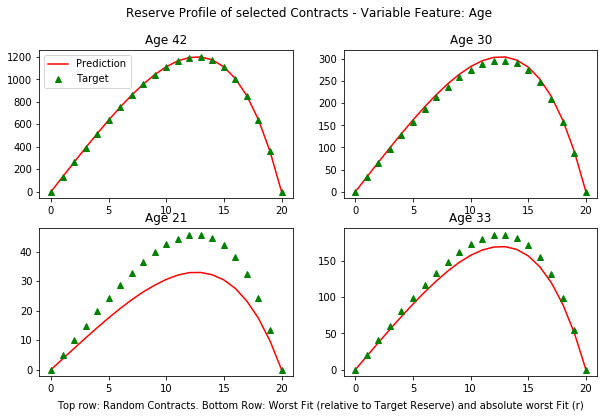

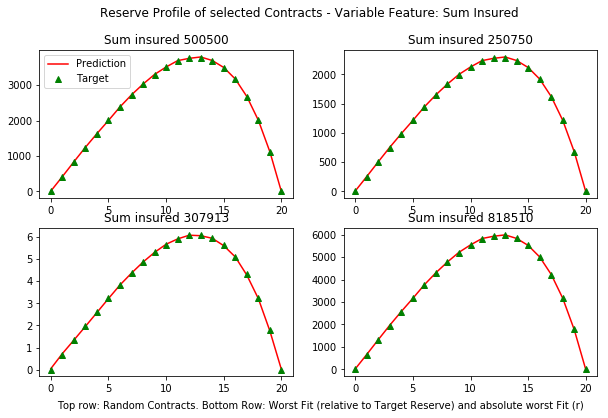

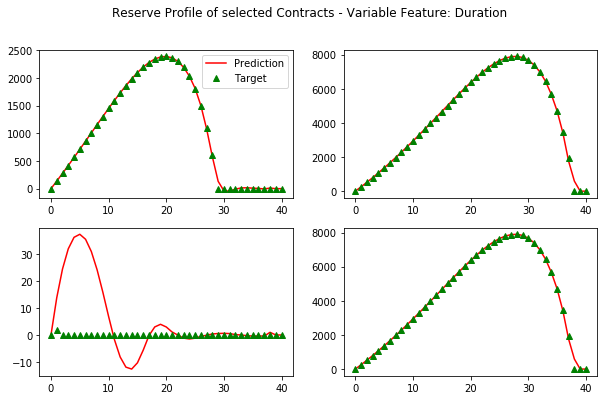

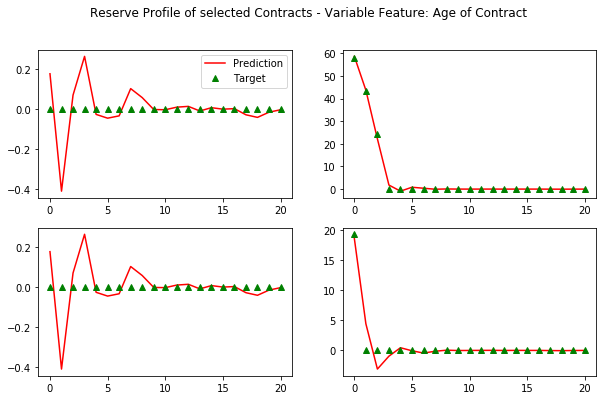

In [43]:
#### Plots of visual Prediction Accuracy

# Predictions
age_pred = model_age.predict(data_age_test)
sum_pred = model_sum.predict(data_sum_test)
dur_pred = model_dur.predict(data_dur_test)
aoc_pred = model_aoc.predict(data_aoc_test)
#age_pred_cum = targets_pred.sum(axis = 0)

# Poorest Predictions absolute
age_pp = np.abs(age_pred-targets_age_test).sum(axis = 1).argmax()
sum_pp = np.abs(sum_pred-targets_sum_test).sum(axis = 1).argmax()
dur_pp = np.abs(dur_pred-targets_dur_test).sum(axis = 1).argmax()
aoc_pp = np.abs(aoc_pred-targets_aoc_test).sum(axis = 1).argmax()

# Poorest Predictions relative (to target reserve)
age_pp_rel = (np.abs(age_pred-targets_age_test).sum(axis = 1)/targets_age_test.sum(axis = 1)).argmax()
sum_pp_rel = (np.abs(sum_pred-targets_sum_test).sum(axis = 1)/targets_sum_test.sum(axis = 1)).argmax()
dur_pp_rel = (np.abs(dur_pred-targets_dur_test).sum(axis = 1)/targets_dur_test.sum(axis = 1)).argmax()
aoc_pp_rel = (np.abs(aoc_pred-targets_aoc_test).sum(axis = 1)/targets_aoc_test.sum(axis = 1)).argmax()

# Single Contract Reserve Point of View

### Age
fig1, axis1 = plt.subplots(2,2, figsize = (10,6))
plt.suptitle('Reserve Profile of selected Contracts - Variable Feature: Age')
fig1.text(.15, .05,'Top row: Random Contracts. Bottom Row: Worst Fit (relative to Target Reserve) and absolute worst Fit (r)')
axis1[0][0].plot(age_pred[0,:], 'r',label='Prediction')
axis1[0][0].plot(targets_age_test[0,:], 'g^', label = 'Target')
axis1[0][0].set_title('Age '+ str(data_age[0]))
axis1[0][0].legend()
axis1[0][1].plot(age_pred[2,:], 'r',targets_age_test[2,:], 'g^')
axis1[0][1].set_title('Age '+ str(data_age[2]))
axis1[1][0].plot(age_pred[age_pp_rel,:], 'r',targets_age_test[age_pp_rel,:], 'g^')
axis1[1][0].set_title('Age '+ str(data_age[age_pp_rel]))
axis1[1][1].plot(age_pred[age_pp,:], 'r',targets_age_test[age_pp,:], 'g^')
axis1[1][1].set_title('Age '+ str(data_age[age_pp]))

### Sum insured
fig2, axis2 = plt.subplots(2,2, figsize = (10,6))
plt.suptitle('Reserve Profile of selected Contracts - Variable Feature: Sum Insured')
fig2.text(.15, .05,'Top row: Random Contracts. Bottom Row: Worst Fit (relative to Target Reserve) and absolute worst Fit (r)')
axis2[0][0].plot(sum_pred[0,:], 'r',label='Prediction')
axis2[0][0].plot(targets_sum_test[0,:], 'g^', label = 'Target')
axis2[0][0].set_title('Sum insured '+ str(data_sum[0]))
axis2[0][0].legend()
axis2[0][1].plot(sum_pred[1,:], 'r',targets_sum_test[1,:], 'g^')
axis2[0][1].set_title('Sum insured '+ str(data_sum[1]))
axis2[1][0].plot(sum_pred[sum_pp_rel,:], 'r',targets_sum_test[sum_pp_rel,:], 'g^')
axis2[1][0].set_title('Sum insured '+ str(data_sum[sum_pp_rel]))
axis2[1][1].plot(sum_pred[sum_pp,:], 'r',targets_sum_test[sum_pp,:], 'g^')
axis2[1][1].set_title('Sum insured '+ str(data_sum[sum_pp]))

### Duration
fig3, axis3 = plt.subplots(2,2, figsize = (10,6))
plt.suptitle('Reserve Profile of selected Contracts - Variable Feature: Duration')
axis3[0][0].plot(dur_pred[0,:], 'r',label='Prediction')
axis3[0][0].plot(targets_dur_test[0,:], 'g^', label = 'Target')
axis3[0][0].legend()
axis3[0][1].plot(dur_pred[1,:], 'r',targets_dur_test[1,:], 'g^')
axis3[1][0].plot(dur_pred[dur_pp_rel,:], 'r',targets_dur_test[dur_pp_rel,:], 'g^')
axis3[1][1].plot(dur_pred[dur_pp,], 'r',targets_dur_test[dur_pp,], 'g^')

### Age of Contract
fig4, axis4 = plt.subplots(2,2, figsize = (10,6))
plt.suptitle('Reserve Profile of selected Contracts - Variable Feature: Age of Contract')
axis4[0][0].plot(aoc_pred[0,:], 'r',label='Prediction')
axis4[0][0].plot(targets_aoc_test[0,:], 'g^', label = 'Target')
axis4[0][0].legend()
axis4[0][1].plot(aoc_pred[1,:], 'r',targets_aoc_test[1,:], 'g^')
axis4[1][0].plot(aoc_pred[aoc_pp_rel,:], 'r',targets_aoc_test[aoc_pp_rel,:], 'g^')
axis4[1][1].plot(aoc_pred[aoc_pp,], 'r',targets_aoc_test[aoc_pp,], 'g^')

# Cummulative Reserve Point of View
#plt.plot(range(n_h), targets_pred_cum, 'r-', range(n_h), targets_test_cum, 'g^')
#plt.title('NN-approximation - cumulative reserve profile')
#plt.legend(['prediction', 'target'])
#plt.show()

In [44]:
#plt.plot(np.abs(age_pred[age_pp,1:-1]-targets_age_test[age_pp,1:-1])/np.abs(targets_age_test[age_pp,1:-1]))
(np.abs(age_pred[:,1:-1]-targets_age_test[:,1:-1])/np.abs(targets_age_test[:,1:-1])).mean(axis=1).mean()
#plt.plot(np.abs(age_pred[50,1:-1]-targets_age_test[50,1:-1])/np.abs(targets_age_test[50,1:-1]))

0.02567553264454554

### Work with scaled Data in the Sum-Insured-Model

In [45]:
# Model Setup
# Sum ins
n_sum_out = targets_sum.shape[1] # length of output
model_sum_sc = Sequential()
model_sum_sc.add(Dense(units = 3*n_sum_out, activation = act1,input_dim = 1 ))
model_sum_sc.add(Dense(units = n_sum_out, activation = act2))
model_sum_sc.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])

In [46]:
# Train Model (with scaled Data)
hist_sum_sc = model_sum_sc.fit(data_sum_train_sc, targets_sum_train,batch_size=10,epochs = N_epochs, validation_split= val_share,verbose = 0)

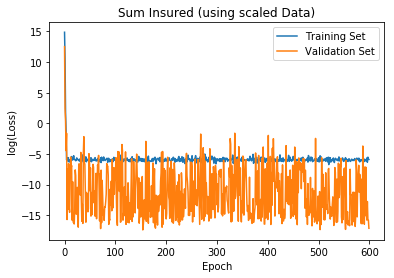

In [47]:
# Revisit Convergence Rate

plt.plot(np.log(hist_sum_sc.history['loss']))
plt.plot(np.log(hist_sum_sc.history['val_loss']))
plt.title('Sum Insured (using scaled Data)')
plt.ylabel('log(Loss)')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper right')

### Transfer this finding to all Feautures

In [48]:
## Models, set ups

# Age
n_age_out = targets_age.shape[1] # length of output
model_age_sc = Sequential()
filepath_age="w-age-dev-{epoch:03d}.hdf5"
checkpoint = ModelCheckpoint(filepath_age, monitor='mae', verbose=0, save_best_only=False, period = chkp_freq )
callbacks_list_age = [checkpoint]
model_age_sc.add(Dense(units = 3*n_age_out, activation = act1,input_dim = 1 ))
model_age_sc.add(Dense(units = n_age_out, activation = act2))
model_age_sc.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])
w_init_age = model_age_sc.get_weights()

# Sum
# Already been setup + trained

# Duration
n_dur_out = targets_dur.shape[1] # length of output
model_dur_sc = Sequential()
model_dur_sc.add(Dense(units = 3*n_dur_out, activation = act1,input_dim = 1 ))
model_dur_sc.add(Dense(units = n_dur_out, activation = act2))
model_dur_sc.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])

# Age of Contract
n_aoc_out = targets_aoc.shape[1] # length of output
model_aoc_sc = Sequential()
model_aoc_sc.add(Dense(units = 3*n_aoc_out, activation = act1,input_dim = 1 ))
model_aoc_sc.add(Dense(units = n_aoc_out, activation = act2))
model_aoc_sc.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])

In [49]:
time3_dim1sc = time.time()

## Train Models
hist_age_sc = model_age_sc.fit(data_age_train_sc, targets_age_train,batch_size=100,epochs = N_epochs,callbacks=callbacks_list_age, validation_split= val_share,verbose = 0)
# Sum model has already been trained
hist_dur_sc = model_dur_sc.fit(data_dur_train_sc, targets_dur_train,batch_size=100,epochs = N_epochs, validation_split= val_share,verbose = 0)
hist_aoc_sc = model_aoc_sc.fit(data_aoc_train_sc, targets_aoc_train,batch_size=100,epochs = N_epochs, validation_split= val_share,verbose = 0)

time4_dim1sc = time.time()

# Save final weight configuration
w_age_final = model_age_sc.get_weights()
w_age_1out_final = model_age_1out.get_weights()

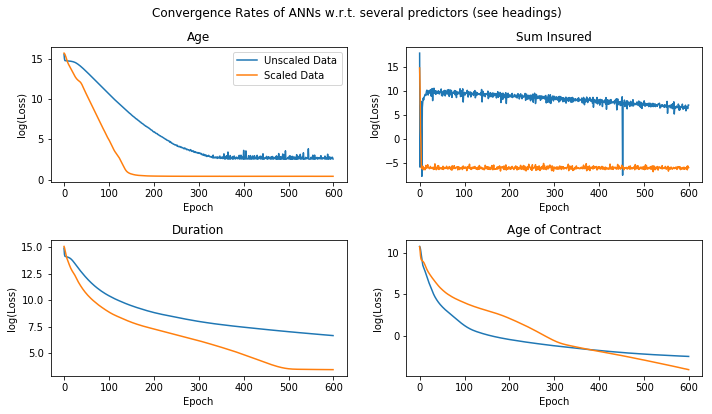

In [50]:
# Plots: Raw vs. Scaled Data Learning
fig, axis = plt.subplots(2,2, figsize = (10,6))
fig. suptitle('Convergence Rates of ANNs w.r.t. several predictors (see headings)')

axis[0][0].plot(np.log(hist_age.history['loss']), label = 'Unscaled Data')
axis[0][0].plot(np.log(hist_age_sc.history['loss']), label = 'Scaled Data')
axis[0][0].legend()
axis[0][0].set_title('Age')
axis[0][0].set_xlabel('Epoch')
axis[0][0].set_ylabel('log(Loss)')

axis[0][1].plot(np.log(hist_sum.history['loss']), label = 'Unscaled Data')
axis[0][1].plot(np.log(hist_sum_sc.history['loss']), label = 'Scaled Data')
axis[0][1].set_title('Sum Insured')
axis[0][1].set_xlabel('Epoch')
axis[0][1].set_ylabel('log(Loss)')

axis[1][0].plot(np.log(hist_dur.history['loss']), label = 'Unscaled Data')
axis[1][0].plot(np.log(hist_dur_sc.history['loss']), label = 'Scaled Data')
axis[1][0].set_title('Duration')
axis[1][0].set_xlabel('Epoch')
axis[1][0].set_ylabel('log(Loss)')

axis[1][1].plot(np.log(hist_aoc.history['loss']), label = 'Unscaled Data')
axis[1][1].plot(np.log(hist_aoc_sc.history['loss']), label = 'Scaled Data')
axis[1][1].set_title('Age of Contract')
axis[1][1].set_xlabel('Epoch')
axis[1][1].set_ylabel('log(Loss)')

#fig.text(.1,-.05, 'Loss is measured by the avererage of each contract´s average squared difference (prediction vs target) over all time points. \n Data used is the Training Data, i.e. 700,000 contracts, multiple time points (Age 21, Sum Insured 21, Duration 40, Age of Contract 59). \n Respective means of (true) Reserve Values (on a log- scale) are: Age '+ str(round(np.log(targets_age.mean().mean())))+', Sum Insured '+ str(round(np.log(targets_sum.mean().mean())))+', Duration '+ str(round(np.log(targets_dur.mean().mean())))+', Age of Contract '+ str(round(np.log(targets_aoc.mean().mean()))))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [51]:
# Interprete values proportionally
res_age_mean = targets_age.mean().mean()
res_sum_mean = targets_sum.mean().mean()
res_dur_mean = targets_dur.mean().mean()
res_aoc_mean = targets_aoc.mean().mean()


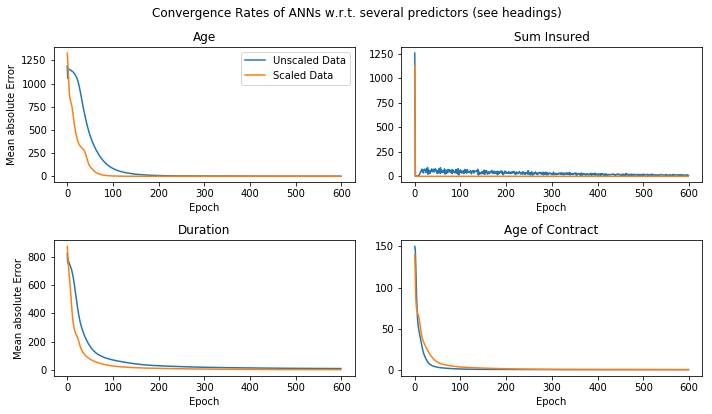

In [52]:
fig, axis = plt.subplots(2,2, figsize = (10,6))
fig. suptitle('Convergence Rates of ANNs w.r.t. several predictors (see headings)')

axis[0][0].plot((hist_age.history['mean_absolute_error']), label = 'Unscaled Data')
axis[0][0].plot((hist_age_sc.history['mean_absolute_error']), label = 'Scaled Data')
axis[0][0].legend()
axis[0][0].set_title('Age')
axis[0][0].set_xlabel('Epoch')
axis[0][0].set_ylabel('Mean absolute Error')

axis[0][1].plot((hist_sum.history['mean_absolute_error']), label = 'Unscaled Data')
axis[0][1].plot((hist_sum_sc.history['mean_absolute_error']), label = 'Scaled Data')
axis[0][1].set_title('Sum Insured')
axis[0][1].set_xlabel('Epoch')
axis[0][1].set_ylabel('')

axis[1][0].plot((hist_dur.history['mean_absolute_error']), label = 'Unscaled Data')
axis[1][0].plot((hist_dur_sc.history['mean_absolute_error']), label = 'Scaled Data')
axis[1][0].set_title('Duration')
axis[1][0].set_xlabel('Epoch')
axis[1][0].set_ylabel('Mean absolute Error')

axis[1][1].plot((hist_aoc.history['mean_absolute_error']), label = 'Unscaled Data')
axis[1][1].plot((hist_aoc_sc.history['mean_absolute_error']), label = 'Scaled Data')
axis[1][1].set_title('Age of Contract')
axis[1][1].set_xlabel('Epoch')
axis[1][1].set_ylabel('')

#fig.text(.1,-.05, 'Mean absolute Error is measured by the avererage of each contract´s average absolute differences (prediction vs target) over all time points. \n Data used is the Training Data, i.e. 700,000 contracts, multiple time points (Age 21, Sum Insured 21, Duration 40, Age of Contract 59). \n Average Reserve Values for the Feature Age (resp. Sum insured, Duration, Age of Contract) is '+str(round(res_age_mean)) + ' (resp. '+str(round(res_sum_mean))+' ,'+str(round(res_dur_mean))+', '+ str(round(res_aoc_mean))+ ').')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [53]:
age_pred_sc = model_age_sc.predict(data_age_test_sc)
sum_pred_sc = model_sum_sc.predict(data_sum_test_sc)
dur_pred_sc = model_dur_sc.predict(data_dur_test_sc)
aoc_pred_sc = model_aoc_sc.predict(data_aoc_test_sc)


#plt.plot(np.abs(age_pred[age_pp,1:-1]-targets_age_test[age_pp,1:-1])/np.abs(targets_age_test[age_pp,1:-1]))
age_rel_dif =(np.abs(age_pred_sc[:,1:-1]-targets_age_test[:,1:-1])/np.abs(targets_age_test[:,1:-1]))
sum_rel_dif =(np.abs(sum_pred_sc[:,1:-1]-targets_sum_test[:,1:-1])/np.abs(targets_sum_test[:,1:-1]))
#dur_rel_dif =(np.abs(dur_pred_sc[:,1:-1]-targets_dur_test[:,1:-1])/np.abs(targets_dur_test[:,1:-1]))
#aoc_rel_dif =(np.abs(aoc_pred_sc[:,1:-1]-targets_aoc_test[:,1:-1])/np.abs(targets_aoc_test[:,1:-1]))

#plt.plot(np.abs(age_pred[50,1:-1]-targets_age_test[50,1:-1])/np.abs(targets_age_test[50,1:-1]))
features = ['Age', 'Sum Insured']
mean_rd = np.array([age_rel_dif.mean(axis=1).mean(),sum_rel_dif.mean(axis=1).mean()])
max_rd = np.array([age_rel_dif.mean(axis=1).max(),sum_rel_dif.mean(axis=1).max()])
min_rd = np.array([age_rel_dif.mean(axis=1).min(),sum_rel_dif.mean(axis=1).min()])

In [54]:
import pandas as pd

df = pd.DataFrame(np.random.randn(2,3), index = ['Age', 'Sum Insured'], columns = ['Mean Relative Difference', 'Max. RD', 'Min. RD'])
df['Mean Relative Difference'] = mean_rd
df['Max. RD'] = max_rd
df['Min. RD'] = min_rd


df

,Mean Relative Difference,Max. RD,Min. RD
Age,6.908575e-03,0.068748,2.932074e-06
Sum Insured,5.113414e-07,0.000085,3.628432e-08


## Comparison of Reserve Profile vs Reserve Value Models
### Looking at relative, absolute errors over the training process

In [55]:
# Common parameters of following models
# act1, act2 = 'relu', 'linear'
# opt, loss_type, metrics_type = 'adam', 'mse', 'mae'
# N_epochs = 100
# val_share = 0.25
# chkp_freq = 25 # checkpoint every 25 epochs

In [56]:
# New Age Model, only trying to replicate a single reserve value (not the whole profile)
filepath_age_1out="w-age_1out-dev-{epoch:03d}.hdf5"
checkpoint = ModelCheckpoint(filepath_age_1out, monitor='mae', verbose=0, save_best_only=False, period = chkp_freq)
callbacks_list_age_1out = [checkpoint]

model_age_1out = Sequential()
model_age_1out.add(Dense(units = 3*n_age_out, activation = act1,input_dim = 1 ))
model_age_1out.add(Dense(units = 1, activation = act2))
model_age_1out.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])

# Old Reserve-Profile-Model: model_age_sc

In [57]:
(dur_std/2)


10.0

In [58]:
## Train Model (using reserve at year 10 to avoid ~0 Reserve Values at Initialization of Contract)
time_1out = int(dur_std/2)+1 # Respect 0-indexing, i.e. year 10 at index 11
hist_age_1out = model_age_1out.fit(data_age_train_sc, targets_age_train[:,time_1out],batch_size=100,epochs = N_epochs,callbacks=callbacks_list_age_1out, validation_split= val_share,verbose = 0)

# Store final weight configuration
w_age_1out_final = model_age_1out.get_weights()

In [80]:
# Calculate Statistics (relative, absolute error - mean/max/min)
# on Reserve-Profile and Reserve-Value Model

grid = range(chkp_freq,N_epochs+1, chkp_freq)
n_grid = len(grid)
error_dev_age = np.zeros([n_grid,3]) # 3 statistics, i.e. mean, max, min
error_dev_age_1out = np.zeros([n_grid,3])
for i in grid:
    num = str(i)
    if len(num)==1:
        num = '00'+num
    if len(num)==2:
        num = '0'+num
    model_age_sc.load_weights('w-age-dev-'+num+'.hdf5')
    cache_age = (np.abs(model_age_sc.predict(data_age_train_sc)[:,time_1out]-targets_age_train[:,time_1out])/targets_age_train[:,time_1out])
    error_dev_age[int(i/chkp_freq)-1,0] = cache_age.mean()
    error_dev_age[int(i/chkp_freq)-1,1] = cache_age.max()
    error_dev_age[int(i/chkp_freq)-1,2] = cache_age.min()

    model_age_1out.load_weights('w-age_1out-dev-'+num+'.hdf5')
    cache_age_1out = (np.abs(model_age_1out.predict(data_age_train_sc).reshape(N_train)-targets_age_train[:,time_1out])/targets_age_train[:,time_1out])
    error_dev_age_1out[int(i/chkp_freq)-1,0] = cache_age_1out.mean()
    error_dev_age_1out[int(i/chkp_freq)-1,1] = cache_age_1out.max()
    error_dev_age_1out[int(i/chkp_freq)-1,2] = cache_age_1out.min()

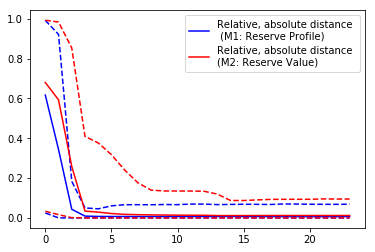

In [81]:
# Plot relative, absolute error (mean + min/max boundaries) 
# for Age Input on Reserve-Profile and Reserve-Value Model
plt.plot(error_dev_age[:,0], '-b', label = 'Relative, absolute distance \n (M1: Reserve Profile)')
plt.plot(error_dev_age[:,1], '--b')
plt.plot(error_dev_age[:,2], '--b')

plt.plot(error_dev_age_1out[:,0], '-r', label = 'Relative, absolute distance \n(M2: Reserve Value)')
plt.plot(error_dev_age_1out[:,1], '--r')
plt.plot(error_dev_age_1out[:,2], '--r')
plt.legend()
plt.show()

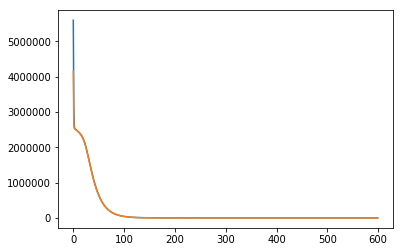

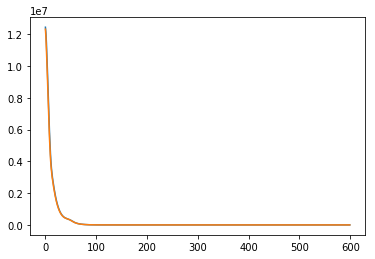

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 63)                126       
_________________________________________________________________
dense_2 (Dense)              (None, 21)                1344      
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 63)                126       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 64        
Total params: 190
Trainable params: 190
Non-trainable params: 0
_________________________________________________________________


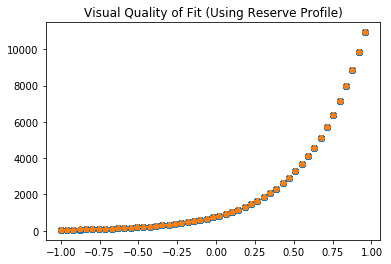

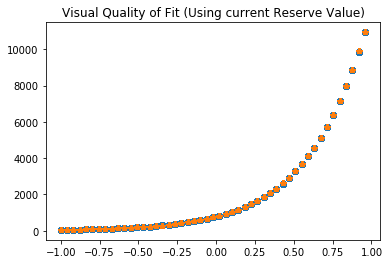

DescribeResult(nobs=70000, minmax=(4.0318543593888505e-07, 0.0687329742439498), mean=0.006905211290290326, variance=0.00016145043171235713, skewness=2.9539503464610135, kurtosis=9.890433534076829)
DescribeResult(nobs=70000, minmax=(0.00040092123201509593, 0.09483459385463576), mean=0.012136552896039786, variance=0.0003944768409461784, skewness=2.2175737815317325, kurtosis=4.938498707127477)


In [84]:
## Visualization of Reserve-Profile vs Reserve-Value Model (for Age Input)

model_age.set_weights(w_age_final)
model_age_1out.set_weights(w_age_1out_final)


plt.plot(hist_age.history['loss'])
plt.plot(hist_age.history['val_loss'])
plt.show()

plt.plot(hist_age_1out.history['loss'])
plt.plot(hist_age_1out.history['val_loss'])
plt.show()

model_age.summary()
model_age_1out.summary()

plt.plot(data_age_train_sc, targets_age_train[:,11], 'o',data_age_train_sc, model_age_sc.predict(data_age_train_sc)[:,11], '*')
plt.title('Visual Quality of Fit (Using Reserve Profile)')
plt.show()
plt.plot(data_age_train_sc, targets_age_train[:,11], 'o',data_age_train_sc, model_age_1out.predict(data_age_train_sc), '*')
plt.title('Visual Quality of Fit (Using current Reserve Value)')
plt.show()

#plt.plot(data_age_train_sc, targets_age_train[:,11]-model_age.predict(data_age_train_sc)[:,11], '*')
#plt.show()
#plt.plot(data_age_train_sc, targets_age_train[:,11], 'o',data_age_train_sc, model_age_1out.predict(data_age_train_sc), '*')
#plt.show()

print(describe(np.abs((targets_age_train[:,11]-model_age_sc.predict(data_age_train_sc)[:,11])/targets_age_train[:,11])))
print(describe(np.abs((targets_age_train[:,11]-model_age_1out.predict(data_age_train_sc).reshape(N_train))/targets_age_train[:,11])))
#targets_age_train[:,11].shape
#model_age_1out.predict(data_age_train_sc)

In [249]:
model_age_1out.predict(np.array(0).reshape(1,1))

array([[774.63513]], dtype=float32)

## Study shift in weight distribution

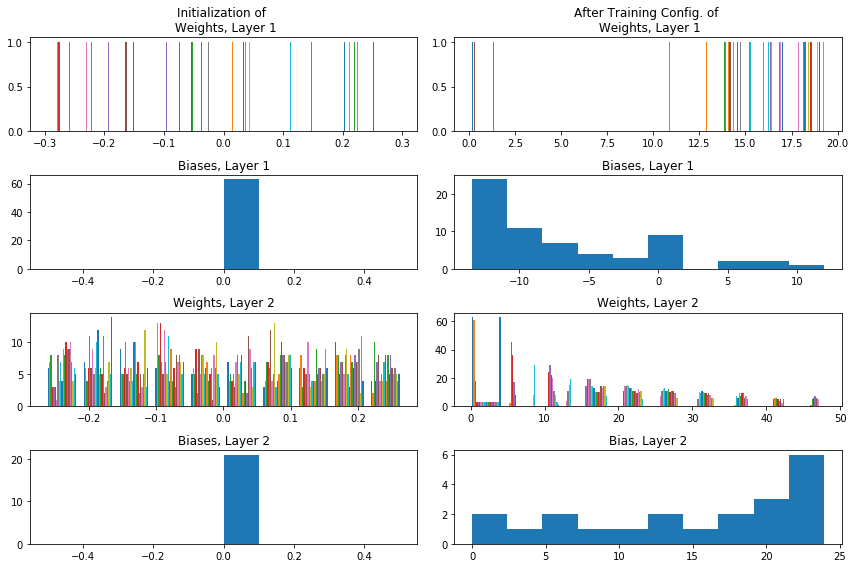

In [102]:
## Look at shifts in weights and biases throughout training

fig, ax = plt.subplots(4,2, figsize = (12,8))
ax[0][0].hist(w_init_age[0])
ax[0][0].set_title('Initialization of \n Weights, Layer 1')
ax[1][0].hist(w_init_age[1])
ax[1][0].set_title('Biases, Layer 1')
ax[2][0].hist(w_init_age[2])
ax[2][0].set_title('Weights, Layer 2')
ax[3][0].hist(w_init_age[3])
ax[3][0].set_title('Biases, Layer 2')
ax[0][1].hist(w_age_final[0])
ax[0][1].set_title('After Training Config. of \n Weights, Layer 1')
ax[1][1].hist(w_age_final[1])
ax[1][1].set_title('Biases, Layer 1')
ax[2][1].hist(w_age_final[2])
ax[2][1].set_title('Weights, Layer 2')
ax[3][1].hist(w_age_final[3])
ax[3][1].set_title('Bias, Layer 2')
plt.tight_layout()
plt.show()

## Check Reduction computation Time for adjusted Weight Initialization (e.g. truncated Normal)

## Check out Recurrent Net

In [160]:
#from keras.layers import RNN, SimpleRNN,LSTM,CuDNNLSTM, Reshape, Lambda, InputLayer, Input, BatchNormalization, Dot

In [36]:
# Common parameters of following models
# act1, act2 = 'relu', 'linear'
#opt, loss_type, metrics_type = 'adam', 'mse', 'mae'
#N_epochs = 100
#val_share = 0.25
#chkp_freq = 25 # checkpoint every 25 epochs

In [37]:
def rnn_age_transform_data(data, n):
    data_transformed = []
    for i in range(len(data)):
        #data_transformed.append(np.int_(np.linspace(data[i], data[i]+n, num =n+1))) # Version 1: Update Current Age
        data_transformed.append(np.repeat(2*(data[i]-age_low)/(age_up-age_low)-1,n+1)) # Version 2: Repetitive Input of Age

    return np.asarray(data_transformed).reshape(len(data),n+1,1)
pass

In [46]:
## Preliminary Data Transformation for LSTM    
data_age_train_rnn = rnn_age_transform_data(data_age_train, dur_std)
data_age_test_rnn = rnn_age_transform_data(data_age_test, dur_std)
#targets_age_train_rnn = (2*targets_age_train-targets_age_train.min())/(targets_age_train.max()-targets_age_train.min())-1
targets_age_train_rnn = (2*targets_age_train-V_age_min)/(V_age_max-V_age_min)-1

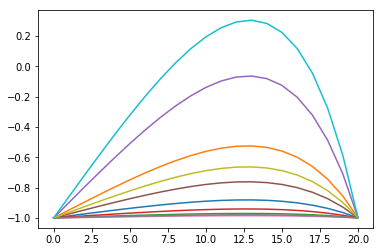

In [47]:
for k in range(10):
    plt.plot(targets_age_train_rnn[k])

In [60]:
# Parameters
# N_epochs, 
batch_size = 100
n_timesteps, n_features, n_output = dur_std+1,1, dur_std+1
tensorboard = TensorBoard(log_dir=cd+"/RNN_age/logs/{}".format(time.time()))

In [61]:
rnn_age = Sequential()
rnn_age.add(CuDNNLSTM(units =n_output, input_shape = (n_timesteps,n_features),return_sequences = True ))
Dropout(0.2)
rnn_age.add(CuDNNLSTM(units =n_output))
Dropout(0.2)
rnn_age.add(Dense(n_output,activation = 'linear'))
rnn_age.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])

rnn_age.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_7 (CuDNNLSTM)     (None, 21, 21)            2016      
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 21)                3696      
_________________________________________________________________
dense_4 (Dense)              (None, 21)                462       
Total params: 6,174
Trainable params: 6,174
Non-trainable params: 0
_________________________________________________________________


In [62]:
rnn_hist = rnn_age.fit(data_age_train_rnn, targets_age_train_rnn, batch_size = 100, epochs = 10, callbacks=[tensorboard])

Epoch 1/10
70000/70000 [==============================] - 6s 84us/step - loss: 0.0311 - mean_absolute_error: 0.0591
Epoch 2/10
70000/70000 [==============================] - 6s 80us/step - loss: 2.1790e-05 - mean_absolute_error: 0.0028
Epoch 3/10
70000/70000 [==============================] - 6s 80us/step - loss: 9.8808e-06 - mean_absolute_error: 0.0019
Epoch 4/10
70000/70000 [==============================] - 6s 81us/step - loss: 9.0005e-06 - mean_absolute_error: 0.0016
Epoch 5/10
70000/70000 [==============================] - 6s 81us/step - loss: 1.4563e-05 - mean_absolute_error: 0.0020
Epoch 6/10
70000/70000 [==============================] - 6s 81us/step - loss: 1.2300e-05 - mean_absolute_error: 0.0016
Epoch 7/10
70000/70000 [==============================] - 6s 81us/step - loss: 4.7274e-06 - mean_absolute_error: 0.0013
Epoch 8/10
70000/70000 [==============================] - 6s 81us/step - loss: 1.7471e-05 - mean_absolute_error: 0.0017
Epoch 9/10
70000/70000 [====================

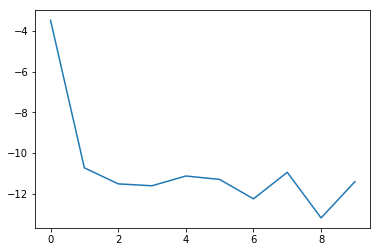

In [63]:
plot_model(rnn_age, to_file= 'rnn_age.png')
plt.plot(np.log(rnn_hist.history['loss']))

In [64]:
#V_max = targets_age_train.max()
pred = (rnn_age.predict(data_age_train_rnn)+1)/2*V_age_max
aim = (targets_age_train_rnn+1)/2*V_age_max
aim.shape[1]

21

In [65]:
# Loss of Re-scaled target-values with final dense layer

describe(np.square(pred-aim).mean(axis=1))

DescribeResult(nobs=70000, minmax=(16.019547353518494, 1300.5015094198989), mean=204.00869935880007, variance=71240.32703390442, skewness=2.04765578566907, kurtosis=4.465764751766388)

No Lambda Layer
DescribeResult(nobs=70000, minmax=(11.0095285684066, 1453.3399525260752), mean=115.12887394918481, variance=51088.21555189596, skewness=4.404591758979849, kurtosis=22.397730335298753)

Incl. Lambda Layer
DescribeResult(nobs=70000, minmax=(115.66999383575289, 2293.160887854171), mean=243.13693596900538, variance=90268.14567503783, skewness=6.464942831337639, kurtosis=41.22472483466508)

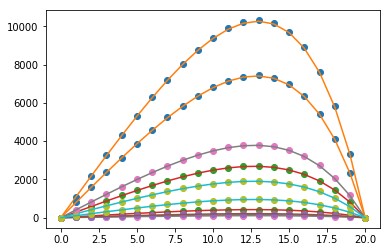

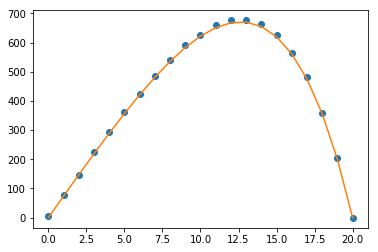

35.15093779122517

In [66]:
for i in range(20,30):
    plt.plot(range(aim.shape[1]), pred[i,:], 'o',range(aim.shape[1]), targets_age_train[i])#aim, '-' )
plt.show()

i=aim.argmax()
plt.plot(range(aim.shape[1]), pred[i,:], 'o',range(aim.shape[1]), targets_age_train[i])
plt.show()
np.square(aim[i]-pred[i]).mean()

In [67]:
### Use Lambda Layer to Re-Scale Output

rnn_age_rescale = Sequential()
rnn_age_rescale.add(CuDNNLSTM(units =n_output, input_shape = (n_timesteps,n_features),return_sequences = True ))
Dropout(0.2)
rnn_age_rescale.add(CuDNNLSTM(units =n_output))
Dropout(0.2)
rnn_age_rescale.add(Dense(n_output,activation = 'linear'))
rnn_age_rescale.add(Lambda(lambda x: (x+1)/2*V_age_max))

rnn_age_rescale.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])

rnn_age_rescale.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_9 (CuDNNLSTM)     (None, 21, 21)            2016      
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 21)                3696      
_________________________________________________________________
dense_5 (Dense)              (None, 21)                462       
_________________________________________________________________
lambda_2 (Lambda)            (None, 21)                0         
Total params: 6,174
Trainable params: 6,174
Non-trainable params: 0
_________________________________________________________________


In [68]:
rnn_rescale_hist = rnn_age_rescale.fit(data_age_train_rnn, targets_age_train, batch_size = 100, epochs = 10, callbacks=[tensorboard])

Epoch 1/10
70000/70000 [==============================] - 6s 85us/step - loss: 1264489.1483 - mean_absolute_error: 379.0534
Epoch 2/10
70000/70000 [==============================] - 6s 81us/step - loss: 1772.1452 - mean_absolute_error: 24.5586
Epoch 3/10
70000/70000 [==============================] - 6s 81us/step - loss: 760.4400 - mean_absolute_error: 15.9840
Epoch 4/10
70000/70000 [==============================] - 6s 81us/step - loss: 870.5125 - mean_absolute_error: 14.1528
Epoch 5/10
70000/70000 [==============================] - 6s 81us/step - loss: 347.8993 - mean_absolute_error: 10.7870
Epoch 6/10
70000/70000 [==============================] - 6s 82us/step - loss: 702.5529 - mean_absolute_error: 13.4780
Epoch 7/10
70000/70000 [==============================] - 6s 82us/step - loss: 264.4749 - mean_absolute_error: 8.5645
Epoch 8/10
70000/70000 [==============================] - 6s 86us/step - loss: 1019.5037 - mean_absolute_error: 11.4342
Epoch 9/10
70000/70000 [==================

In [69]:
pred_rescaled = rnn_age_rescale.predict(data_age_train_rnn)
pred_test_rescaled = rnn_age_rescale.predict(data_age_test_rnn)

In [70]:
describe((np.square(pred_rescaled - targets_age_train)).mean(axis=1))

DescribeResult(nobs=70000, minmax=(10.02587414102315, 1082.424648723978), mean=82.76274022752443, variance=26110.78910644149, skewness=4.978030212587186, kurtosis=27.152751672828256)

## Increase Dimension of Model-Input

In [71]:
# transform 4-dim feature data to RNN suitable input

def data_full_transform(data, n_aim):
    
    n_features = data.shape[1]
    n_len = data.shape[0]
    data_new = []

    # Aim: Transform n_len x n_features matrix to n_len x n_aim (=dur_max+1) x n_features 3D-array
    
    for i in range(n_len):
        step1 = np.tile(data[i,],(data[i,2]-data[i,3],1)) # repeat input for rem. duration
        step2 = np.tile(np.repeat(-1,n_features),(n_aim-data[i,2]+data[i,3],1))
        data_new.append(np.concatenate((step1,step2)))
        
    return np.asarray(data_new).reshape(n_len,n_aim, n_features)

In [72]:
data_rnn = data_full_transform(data, dur_max+1)

In [73]:
matured_default_value = -5

# Work with scaled data
data_rnn_sc = np.copy(data_rnn.astype('double'))
# Scale Age
data_rnn_sc[:,:,0] = 2*(data_rnn_sc[:,:,0]-age_low)/(age_up-age_low)-1
contract_matured_age = data_rnn_sc[:,:,0]== data_rnn_sc[:,:,0].min()
data_rnn_sc[contract_matured_age,0] = matured_default_value
# Scale Sum Insured
data_rnn_sc[:,:,1] = 2*(data_rnn_sc[:,:,1]-Sum_min)/(Sum_max-Sum_min)-1
contract_matured_sum = data_rnn_sc[:,:,1]== data_rnn_sc[:,:,1].min()
data_rnn_sc[contract_matured_sum,1] = matured_default_value
# Scale Duration
data_rnn_sc[:,:,2] = 2*(data_rnn_sc[:,:,2]-dur_min)/(dur_max-dur_min)-1
contract_matured_dur = data_rnn_sc[:,:,2]== data_rnn_sc[:,:,2].min()
data_rnn_sc[contract_matured_dur,2] = matured_default_value
# Scale Age of Contract
data_rnn_sc[:,:,3] = 2*(data_rnn_sc[:,:,3]-aoc_min)/(aoc_max-aoc_min)-1
contract_matured_aoc = data_rnn_sc[:,:,3]== data_rnn_sc[:,:,3].min()
data_rnn_sc[contract_matured_aoc,3] = matured_default_value

In [74]:
# Split Transformed Data into Training and Test Set
data_rnn_train_sc = data_rnn_sc[0:N_train,:,:]
data_rnn_test_sc = data_rnn_sc[N_train:,:,:]
data_rnn_test_sc.shape

(30000, 41, 4)

In [631]:
#describe(data_rnn[:,:,0])
#plt.hist(data_rnn_sc[np.logical_not(contract_matured_dur),2])#, data_rnn[:,:,0]
#plt.show()
#plt.hist(data_rnn[np.logical_not(contract_matured_dur),2])
#plt.show()
#plt.hist(data_dur_sc)
#plt.show()

In [75]:
### Logarithmize + Scale targets
targets_rnn_sc = 2*(np.log(1+targets)-0)/(np.log(1+V_max)-0)-1 ## implicitely used by Lambda Layer

In [398]:
# Parameters
# N_epochs, 
batch_size = 100
n_timesteps, n_features, n_output = dur_max+1,n_in, dur_max+1
tensorboard = TensorBoard(log_dir="logs/rnn_full/{}".format(time.time()))

In [399]:
filepath_age=cd+"/checkpoints/RNN_full/rnn_full_weights-{epoch:03d}.hdf5"
checkpoint = ModelCheckpoint(filepath_age, monitor='mae', verbose=0, save_best_only=False, period = chkp_freq )
callbacks_list = [checkpoint] #[checkpoint, tensorboard]
#hist_age = model_age.fit(data_age_train, targets_age_train,batch_size=100,epochs = N_epochs,callbacks=callbacks_list, validation_split= val_share,verbose = 0)

In [405]:
# Setup of Multidim. Feature Model
rnn_full = Sequential()
rnn_full.add(InputLayer(input_shape = (n_timesteps,n_features), name = 'Input Lyer'))
#rnn_full.add(Lambda(lambda x: 0 if x==matured_default_value else x))
#rnn_full.add(BatchNormalization(axis = -1))
#rnn_full.add(Lambda(lambda x: 0 if np.isnan(x) else x))
rnn_full.add(CuDNNLSTM(units =2*n_output, return_sequences = True, name = 'Layer 1'))
Dropout(0.2)
#rnn_full.add(BatchNormalization())
rnn_full.add(CuDNNLSTM(units =n_output)name = 'Layer 2')#, return_sequences=True))
Dropout(0.2)
#rnn_full.add(BatchNormalization())
#rnn_full.add(CuDNNLSTM(units =n_output))
#Dropout(0.2)
rnn_full.add(Dense(n_output,activation = 'linear',name = 'Layer 3'))
rnn_full.add(Lambda(lambda x: tf.exp((x+1)/2*np.log(1+V_max))-1))

rnn_full.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])

rnn_full.summary()

w_rnn_full_init = rnn_full.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_178 (CuDNNLSTM)   (None, 41, 82)            28864     
_________________________________________________________________
cu_dnnlstm_179 (CuDNNLSTM)   (None, 41)                20500     
_________________________________________________________________
dense_78 (Dense)             (None, 41)                1722      
_________________________________________________________________
lambda_17 (Lambda)           (None, 41)                0         
Total params: 51,086
Trainable params: 51,086
Non-trainable params: 0
_________________________________________________________________


In [406]:
#rnn_full_hist = rnn_full.fit(data_rnn_train_sc, targets_rnn_sc[0:N_train,:], batch_size = batch_size, epochs=20, verbose=1)
rnn_full_hist = rnn_full.fit(data_rnn_train_sc, targets_train, batch_size = batch_size, epochs=100, verbose=1, validation_split=val_share, callbacks = callbacks_list)
w_rnn_full_final = rnn_full.get_weights()

Train on 52500 samples, validate on 17500 samples
Epoch 1/100
52500/52500 [==============================] - 15s 282us/step - loss: 106836755.4557 - mean_absolute_error: 2236.4022 - val_loss: 48202088.1514 - val_mean_absolute_error: 1533.6214
Epoch 2/100
52500/52500 [==============================] - 10s 194us/step - loss: 31734974.9199 - mean_absolute_error: 1295.4118 - val_loss: 14583164.5129 - val_mean_absolute_error: 1022.4371
Epoch 3/100
52500/52500 [==============================] - 10s 192us/step - loss: 22166538.8807 - mean_absolute_error: 1074.5373 - val_loss: 11132961.1864 - val_mean_absolute_error: 801.6360
Epoch 4/100
52500/52500 [==============================] - 11s 200us/step - loss: 12433480.2896 - mean_absolute_error: 868.2598 - val_loss: 6112707.1214 - val_mean_absolute_error: 662.3411
Epoch 5/100
52500/52500 [==============================] - 10s 198us/step - loss: 6765180.6669 - mean_absolute_error: 679.6583 - val_loss: 6798281.7386 - val_mean_absolute_error: 701.83

52500/52500 [==============================] - 10s 187us/step - loss: 2348330.2083 - mean_absolute_error: 255.9162 - val_loss: 658348.5110 - val_mean_absolute_error: 145.9903
Epoch 45/100
52500/52500 [==============================] - 10s 187us/step - loss: 1417397.1748 - mean_absolute_error: 209.8615 - val_loss: 723396.5817 - val_mean_absolute_error: 154.8689
Epoch 46/100
52500/52500 [==============================] - 10s 189us/step - loss: 1321125.4831 - mean_absolute_error: 211.0287 - val_loss: 632386.5739 - val_mean_absolute_error: 139.6186
Epoch 47/100
52500/52500 [==============================] - 10s 189us/step - loss: 1018293.5521 - mean_absolute_error: 188.5501 - val_loss: 774404.3562 - val_mean_absolute_error: 165.9952
Epoch 48/100
52500/52500 [==============================] - 10s 188us/step - loss: 1513568.4932 - mean_absolute_error: 223.0208 - val_loss: 1172652.3742 - val_mean_absolute_error: 185.9258
Epoch 49/100
52500/52500 [==============================] - 10s 188us/st

Epoch 88/100
52500/52500 [==============================] - 10s 193us/step - loss: 1299786.5089 - mean_absolute_error: 179.2577 - val_loss: 444819.0650 - val_mean_absolute_error: 136.8221
Epoch 89/100
52500/52500 [==============================] - 10s 193us/step - loss: 572952.6964 - mean_absolute_error: 126.5047 - val_loss: 1936019.1609 - val_mean_absolute_error: 303.4092
Epoch 90/100
52500/52500 [==============================] - 10s 194us/step - loss: 1580884.6872 - mean_absolute_error: 217.7496 - val_loss: 413759.4283 - val_mean_absolute_error: 106.8904
Epoch 91/100
52500/52500 [==============================] - 10s 192us/step - loss: 427379.7573 - mean_absolute_error: 118.2481 - val_loss: 551912.6543 - val_mean_absolute_error: 122.1814
Epoch 92/100
52500/52500 [==============================] - 10s 192us/step - loss: 662195.8574 - mean_absolute_error: 126.3871 - val_loss: 5531393.4750 - val_mean_absolute_error: 533.3684
Epoch 93/100
52500/52500 [==============================] - 1

In [407]:
#pred_rnn_full = np.exp((rnn_full.predict(data_rnn_train_sc) +1)/2*np.log(1+V_max))-1 # Case 1: No Re-Scaling Lambda Layer in Model
pred_rnn_full = rnn_full.predict(data_rnn_train_sc)

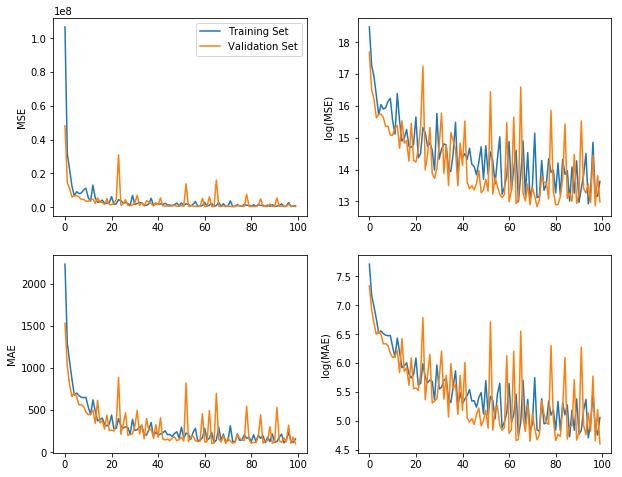

In [497]:
fig, ax = plt.subplots(2,2,figsize = (10,8))
ax[0,0].plot(rnn_full_hist.history['loss'], label = 'Training Set') 
ax[0,0].plot(rnn_full_hist.history['val_loss'], label = 'Validation Set')
ax[0,0].set_ylabel('MSE')
ax[0,0].legend()
ax[0,1].plot(np.log(rnn_full_hist.history['loss']))
ax[0,1].plot(np.log(rnn_full_hist.history['val_loss']))
ax[0,1].set_ylabel('log(MSE)')
ax[1,0].plot(rnn_full_hist.history['mean_absolute_error']) 
ax[1,0].plot(rnn_full_hist.history['val_mean_absolute_error'])
ax[1,0].set_ylabel('MAE')
ax[1,1].plot(np.log(rnn_full_hist.history['mean_absolute_error']))
ax[1,1].plot(np.log(rnn_full_hist.history['val_mean_absolute_error']))
ax[1,1].set_ylabel('log(MAE)')
plt.show()

In [408]:
np.isinf( pred_rnn_full).sum(), pred_rnn_full.shape
(pred_rnn_full == 0).sum()
pred_rnn_full.min(), V_max

(-1.0, 776521.0699188821)

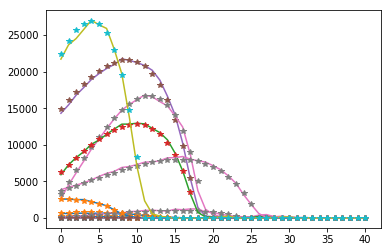

array([4.778876e+03, 2.425632e+04, 2.550262e+01, ..., 2.622333e+03,
       7.020197e+01, 4.170243e+00], dtype=float32)

In [437]:
for i in range(150,165):
    plt.plot(pred_rnn_full[i,:], '-')
    plt.plot(targets_train[i,:], '*')
    
plt.show()
#i=5   
#plt.plot(pred_rnn_full[i,])
#data_train[i,:], targets_train[i,], pred_rnn_full[i,]
pred_rnn_full.max(axis=1)

#### Relative discrepancy (ANN vs Classical Calc.), for non-zero targets

In [611]:
index = targets_train>0.0
index
describe(np.abs(pred_rnn_full[index]-targets_train[index])/targets_train[index])


DescribeResult(nobs=731564, minmax=(3.042854863542854e-08, 333.37080265221226), mean=0.22797753223266165, variance=1.7526804966042515, skewness=90.55575889972712, kurtosis=14019.620724117443)

#### Absolute discrepancy (ANN vs Classical Calc.), for zero-value targets

In [616]:
print(describe(np.abs(pred_rnn_full[np.logical_not(index)]-targets_train[np.logical_not(index)])))
print('Total discrepancy = '+str((pred_rnn_full[np.logical_not(index)]).sum()))

DescribeResult(nobs=2138436, minmax=(0.0, 47859.546875), mean=36.57557553754084, variance=183230.7596417007, skewness=37.64212297245885, kurtosis=2038.436725317689)
Total discrepancy = 76096104.0


In [ ]:
pos = (np.abs(pred_rnn_full-targets_train).max(axis=1)).argmax()
pos
data_train[pos,:], targets_train[pos,], np.abs(targets_train[pos,]- pred_rnn_full[pos,]).max()

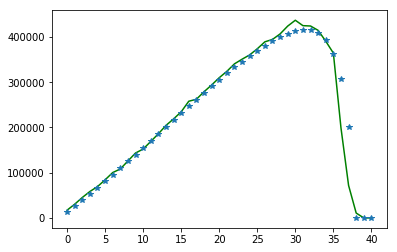

array([    66, 591168,     39,      1])

In [441]:
plt.plot(pred_rnn_full[pos,], '-g')
plt.plot(targets_train[pos,],'*')
plt.show()
data_train[pos,:]

In [445]:
# Evaluate on Test Set
pred_rnn_full_test = rnn_full.predict(data_rnn_test_sc)
aim = targets_test

In [480]:
len(range(dur_max+1)), np.hstack(np.array([np.repeat(0.05, 15),np.repeat(0.1, 15),np.repeat(0.2, dur_max-30)]))


(41, array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 ,
        0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.2 , 0.2 , 0.2 ,
        0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ]))

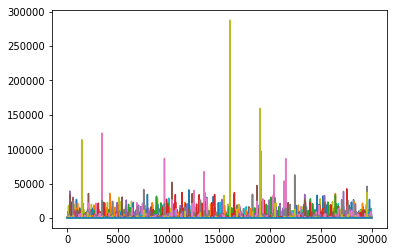

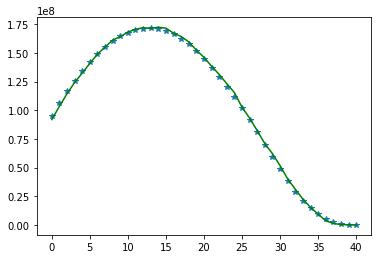

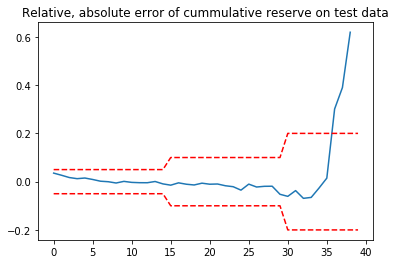

(DescribeResult(nobs=6, minmax=(0.0, 9578288.66524623), mean=2952697.655956352, variance=14231402951838.072, skewness=0.9812219592835109, kurtosis=-0.4863408344344218),
 DescribeResult(nobs=6, minmax=(-158.58882, 9438257.0), mean=2442960.0, variance=13596024000000.0, skewness=1.3275847434997559, kurtosis=0.23166545602127853),
 array([9578288.66524623, 5147600.14243214, 2109646.7356863 ,
         880650.39237344,       0.        ,       0.        ]),
 array([ 9.4382570e+06,  3.5970125e+06,  1.2871521e+06,  3.3538588e+05,
         1.1060676e+02, -1.5858882e+02], dtype=float32))

In [485]:
plt.plot(np.abs(aim-pred_rnn_full_test))
plt.show()
plt.plot(aim.sum(axis=0), '*',pred_rnn_full_test.sum(axis=0), '-g')
plt.show()
aim_cum = aim.sum(axis=0)
pred_cum = pred_rnn_full_test.sum(axis=0)
index = aim_cum >0
plt.plot((aim_cum[index]-pred_cum[index])/np.abs(aim_cum[index]))
plt.plot(range(dur_max), np.hstack(np.array([np.repeat(0.05, 15),np.repeat(0.1, 15),np.repeat(0.2, dur_max-30)])), '--r')
plt.plot(range(dur_max), -np.hstack(np.array([np.repeat(0.05, 15),np.repeat(0.1, 15),np.repeat(0.2, dur_max-30)])), '--r')
plt.title('Relative, absolute error of cummulative reserve on test data')
plt.show()
#plt.plot(aim_cum[-10:]-pred_cum[-10:])
describe(aim_cum[35:]), describe(pred_cum[35:]), aim_cum[35:], pred_cum[35:]

## Study Weight Distribution of RNN for full Data

In [609]:
## Look at shifts in weights and biases throughout training

#fig, ax = plt.subplots(4,2, figsize = (12,8))
#ax[0][0].hist(w_rnn_full_init[0])
#ax[0][0].set_title('Initialization of \n Weights, Layer 1')
#ax[1][0].hist(w_rnn_full_init[1])
#ax[1][0].set_title('Biases, Layer 1')
#ax[2][0].hist(w_rnn_full_init[2])
#ax[2][0].set_title('Weights, Layer 2')
#ax[3][0].hist(w_rnn_full_init[3])
#ax[3][0].set_title('Biases, Layer 2')
#ax[0][1].hist(w_rnn_full_final[0])
#ax[0][1].set_title('After Training Config. of \n Weights, Layer 1')
#ax[1][1].hist(w_rnn_full_final[1])
#ax[1][1].set_title('Biases, Layer 1')
#ax[2][1].hist(w_rnn_full_final[2])
#ax[2][1].set_title('Weights, Layer 2')
#ax[3][1].hist(w_rnn_full_final[3])
#ax[3][1].set_title('Bias, Layer 2')
#plt.tight_layout()
#plt.show()

## Perform Cross Validation

In [672]:
# General function to set up a model

def create_rnn_model(nodes, dropout_option, dropout_share, input_shape, n_output, optimizer_type,loss_type, metric_type, epochs = 1, valsplit = 0.25, batch_size = 100): #, init_style):
    model = Sequential()
    model.add(CuDNNLSTM(units = nodes[0], input_shape = input_shape,return_sequences = True)) #,kernel_initializer=init -> for potential later use
    # Optional Dropout
    if dropout_option == True: 
        model.add(Dropout(dropout_share))#[0]))
    for i in range(1,len(nodes)-1):
        model.add(CuDNNLSTM(units = nodes[i], return_sequences = True), name = 'Layer'+i)
        # Optional Dropout
        if dropout_option == True:
            model.add(Dropout(dropout_share))#[i]))    
    model.add(CuDNNLSTM(units=nodes[len(nodes)-1],return_sequences = False))
    # Final Dense Layer
    model.add(Dense(n_output))
    
    # Compile model
    model.compile(loss = loss_type, optimizer = optimizer_type, metrics = [metric_type] )
    
    model.summary()
    return model

In [674]:
# Step 1: Define range of parameters for CrossValidation
model_width = [[n_output, n_output]] #,[3*n_output, n_output],[3*n_output, 3*n_output],[5*n_output, 3*n_output, n_output] ]
dropoutOption = [True, False]
dropoutShare = [0.2]#[0.2,0.2] #[[0.5, 0.5],[0.2, 0.2],  [0.2, 0.1], [0.1,0.1]]
inputshape = [(n_timesteps,n_features)]
n_out = [n_output]
optimizers = ['adam', 'AdaDelta'] #,keras.optimizers.SGD(lr=0.01, nesterov=True)]
losses = ['mse']#,'mean_absolute_percentage_error' ]
metrics = ['mae'] #['mean_absolute_error', 'accuracy']
N_epochs_cv = [1]
batch_cv = [100]#[250, 100, 50]
validation_share_cv = [0.2] #[0.4,0.25, 0.1]

# Combine parameters
param_grid = dict(epochs = N_epochs_cv, batch_size = batch_cv,validation_split =validation_share_cv, nodes = model_width,dropout_option = dropoutOption, dropout_share = dropoutShare, input_shape = inputshape, n_output = n_out, optimizer_type = optimizers, loss_type = losses, metric_type = metrics)

In [1]:
# Step 2: Initialize model
model = KerasRegressor(build_fn=create_rnn_model, verbose = 0)

# Step 3: Initialize GridCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv =3, n_jobs=1)

NameError: name 'KerasRegressor' is not defined

In [ ]:
# Step 4: Fit Models on Grid
grid_result = grid.fit(data_rnn_train_sc, targets_train )

In [692]:
grid_result.best_score_, grid_result.best_params_, grid_result.score

(-350604324.1742857,
 {'batch_size': 100,
  'dropout_option': True,
  'dropout_share': 0.2,
  'epochs': 1,
  'input_shape': (41, 4),
  'loss_type': 'mse',
  'metric_type': 'mae',
  'n_output': 41,
  'nodes': [41, 41],
  'optimizer_type': 'AdaDelta',
  'validation_split': 0.2},
 <bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score='raise-deprecating',
        estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001C11F047C50>,
        fit_params=None, iid='warn', n_jobs=None,
        param_grid={'epochs': [1], 'batch_size': [100], 'validation_split': [0.2], 'nodes': [[41, 41]], 'dropout_option': [True, False], 'dropout_share': [0.2], 'input_shape': [(41, 4)], 'n_output': [41], 'optimizer_type': ['adam', 'AdaDelta'], 'loss_type': ['mse'], 'metric_type': ['mae']},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=None, verbose=0)>)

In [666]:
grid_result.best_score_, grid_result.best_params_

(-350694957.46874285,
 {'batch_size': 100,
  'dropout_option': False,
  'dropout_share': 0.2,
  'epochs': 1,
  'input_shape': (41, 4),
  'loss_type': 'mse',
  'metric_type': 'mae',
  'n_output': 41,
  'nodes': [41, 41],
  'optimizer_type': 'AdaDelta',
  'validation_split': 0.2})

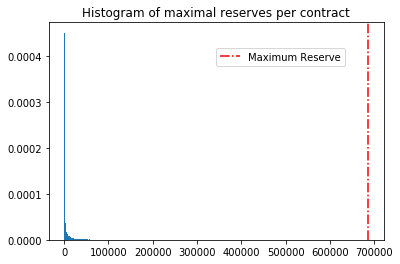

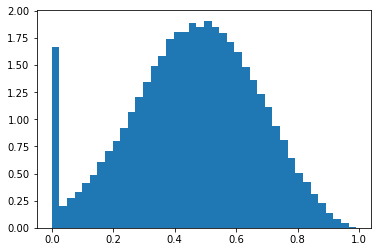

In [526]:
# Check Scaling feature of multivariate data

plt.hist(targets.max(axis=1), bins = 500, density = True)
plt.axvline(targets.max(axis=1).max(),color = 'red', linestyle = '-.', label = 'Maximum Reserve')
plt.legend(loc=(0.5,0.8))
plt.title('Histogram of maximal reserves per contract')
plt.show()
plt.hist(np.log(1+targets.max(axis=1))/np.log(1+V_max), bins = 40, density=True)
plt.show('Histogram of maximal reserves per contract on a log.-scale')


## Model to check IF Reserve Required

In [229]:
targets_qualitative = (targets!=0).astype('int')
targets_qualitative_train = targets_qualitative[0:N_train,]
targets_qualitative_test = targets_qualitative[N_train:,]

In [232]:
targets_qualitative_train, data_train_sc[:,2:]

(array([[0, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]), array([[ 0.        , -1.        ],
        [ 0.47368421, -0.84615385],
        [-0.52631579, -0.69230769],
        ...,
        [ 0.73684211, -0.07692308],
        [-0.26315789, -0.58974359],
        [-0.57894737, -0.69230769]]))

In [254]:
## Setup of Model

rnn_qualitative = Sequential()
rnn_qualitative.add(InputLayer(input_shape = (n_timesteps,2)))

rnn_qualitative.add(CuDNNLSTM(units =2*n_output, return_sequences = True ))
Dropout(0.2)

rnn_qualitative.add(CuDNNLSTM(units =n_output))#, return_sequences=True))
Dropout(0.2)

rnn_qualitative.add(Dense(n_output,activation = 'linear'))

rnn_qualitative.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])

rnn_qualitative.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_160 (CuDNNLSTM)   (None, 41, 82)            28208     
_________________________________________________________________
cu_dnnlstm_161 (CuDNNLSTM)   (None, 41)                20500     
_________________________________________________________________
dense_69 (Dense)             (None, 41)                1722      
Total params: 50,430
Trainable params: 50,430
Non-trainable params: 0
_________________________________________________________________


In [255]:
hist_rnn_qualitative = rnn_qualitative.fit(data_rnn_train_sc[:,:,2:], targets_qualitative_train, epochs=10, batch_size=batch_size, validation_split=val_share, verbose = 1)

Train on 52500 samples, validate on 17500 samples
Epoch 1/10
52500/52500 [==============================] - 13s 245us/step - loss: 0.0278 - mean_absolute_error: 0.0904 - val_loss: 0.0096 - val_mean_absolute_error: 0.0503
Epoch 2/10
52500/52500 [==============================] - 10s 183us/step - loss: 0.0076 - mean_absolute_error: 0.0432 - val_loss: 0.0062 - val_mean_absolute_error: 0.0394
Epoch 3/10
52500/52500 [==============================] - 10s 184us/step - loss: 0.0053 - mean_absolute_error: 0.0353 - val_loss: 0.0046 - val_mean_absolute_error: 0.0318
Epoch 4/10
52500/52500 [==============================] - 10s 186us/step - loss: 0.0042 - mean_absolute_error: 0.0302 - val_loss: 0.0041 - val_mean_absolute_error: 0.0295
Epoch 5/10
52500/52500 [==============================] - 10s 186us/step - loss: 0.0034 - mean_absolute_error: 0.0264 - val_loss: 0.0031 - val_mean_absolute_error: 0.0259
Epoch 6/10
52500/52500 [==============================] - 10s 191us/step - loss: 0.0026 - mean_

In [272]:
data_rnn_train_sc[i:i+1,:,2:].shape

(1, 41, 2)

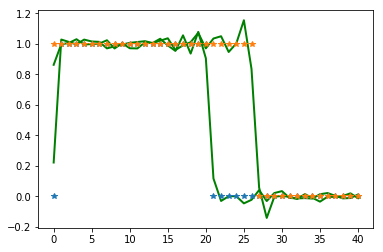

In [290]:
#plt.plot(model_reserve_yn.predict(np.array([15,3]).reshape(1,2)))
#plt.show()
#plt.plot(rnn_qualitative.predict(np.array([21,0]))[0]) 
for i in range(2):
    plt.plot(rnn_qualitative.predict(data_rnn_train_sc[i:i+1,:,2:])[0], '-g', linewidth=2)
    plt.plot(targets_qualitative_train[i], '*')

In [284]:
rnn_qualitative.predict(data_rnn_train_sc[i:i+1,:,2:])

array([[ 2.2144535e-01,  1.0278745e+00,  1.0120683e+00,  9.9567056e-01,
         1.0274907e+00,  1.0150688e+00,  1.0126630e+00,  9.6977961e-01,
         9.8312145e-01,  9.9528474e-01,  1.0058767e+00,  1.0115670e+00,
         1.0170239e+00,  1.0048141e+00,  1.0328677e+00,  9.8925918e-01,
         9.5320398e-01,  1.0554196e+00,  9.3573546e-01,  1.0779390e+00,
         9.0510029e-01,  1.1656759e-01, -3.0742627e-02,  3.8845278e-04,
         3.8160104e-04, -4.6423279e-02, -2.3194406e-02,  4.0517718e-02,
        -3.1162545e-02,  2.1269340e-02,  3.3859354e-02, -1.0843523e-02,
        -1.4028782e-02, -1.1919856e-02, -1.4908349e-02,  1.3607129e-02,
         2.1243446e-02,  3.2203561e-03, -1.3606610e-02, -1.1437334e-02,
         1.1668924e-02]], dtype=float32)

## Split Model into 2 Pieces: Classification if Reserve required & Actual Value Prediction

In [211]:
INPUT_FULL = Input(shape=(n_timesteps,n_features))
INPUT_PART = Input(shape=(n_timesteps,2))

branch1_in = CuDNNLSTM(units =2*n_output, return_sequences = True )(INPUT_PART)
branch1_1 = Dropout(0.2)(branch1_in)
#branch1_2 = CuDNNLSTM(units =2*n_output, return_sequences = True )(branch1_1)
#branch1_3 = Dropout(0.2)(branch1_2)
branch1_4 = CuDNNLSTM(units =2*n_output)(branch1_1)
branch1_5 = Dropout(0.2)(branch1_4)
branch1_out = Dense(n_output,activation='softmax')(branch1_5)

branch2_in = CuDNNLSTM(units =2*n_output, return_sequences = True )(INPUT_FULL)
branch2_1 = Dropout(0.2)(branch2_in)
branch2_2 = CuDNNLSTM(units =2*n_output, return_sequences = True )(branch2_1)
branch2_3 = Dropout(0.2)(branch2_2)
branch2_4 = CuDNNLSTM(units =2*n_output)(branch2_3)
branch2_5 = Dropout(0.2)(branch2_4)
branch2_out = Dense(n_output,activation='linear')(branch2_5)

merged = multiply([branch1_out, branch2_out])
merged_out = Lambda(lambda x: tf.exp((x+1)/2*np.log(1+V_max))-1)(merged)

rnn_combined = Model(inputs=[INPUT_PART, INPUT_FULL], outputs = merged_out)

In [212]:
rnn_combined.compile(optimizer=opt,loss=loss_type,metrics= [metrics_type])
rnn_combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           (None, 41, 4)        0                                            
__________________________________________________________________________________________________
cu_dnnlstm_149 (CuDNNLSTM)      (None, 41, 82)       28864       input_55[0][0]                   
__________________________________________________________________________________________________
input_56 (InputLayer)           (None, 41, 2)        0                                            
__________________________________________________________________________________________________
dropout_140 (Dropout)           (None, 41, 82)       0           cu_dnnlstm_149[0][0]             
__________________________________________________________________________________________________
cu_dnnlstm

In [213]:
hist_rnn_combined = rnn_combined.fit([data_rnn_train_sc[:,:,2:],data_rnn_train_sc],targets_train, epochs =10,batch_size=batch_size, validation_split=val_share, verbose=1 )

Train on 52500 samples, validate on 17500 samples
Epoch 1/10
52500/52500 [==============================] - 34s 643us/step - loss: 332582325.7200 - mean_absolute_error: 3874.8334 - val_loss: 364631437.0057 - val_mean_absolute_error: 3899.6605
Epoch 2/10
52500/52500 [==============================] - 28s 538us/step - loss: 326729206.3371 - mean_absolute_error: 4156.6857 - val_loss: 365324388.7429 - val_mean_absolute_error: 4292.9458
Epoch 3/10
52500/52500 [==============================] - 28s 541us/step - loss: 329835026.1676 - mean_absolute_error: 4381.5489 - val_loss: 362140156.8343 - val_mean_absolute_error: 4607.4979
Epoch 4/10
52500/52500 [==============================] - 28s 540us/step - loss: 270923304.8600 - mean_absolute_error: 3395.3784 - val_loss: 240552174.0571 - val_mean_absolute_error: 3155.4028
Epoch 5/10
52500/52500 [==============================] - 28s 537us/step - loss: 286185920.1267 - mean_absolute_error: 3954.6077 - val_loss: 360395719.9657 - val_mean_absolute_er

In [215]:
plot_model(rnn_combined, to_file= 'rnn_combined.png')


In [ ]:
## Perform k-fold CV

def get_model_rnn():
    
    
    return model

# Part II - Clustering of Contracts (Supervised by cummulative reserve)

In [319]:
## Baseline
agglomeration_max = 200
agglomeration_rel = 0.1
N_clusters = min(int(N_contracts*agglomeration_rel),agglomeration_max)
data_clustered = cluster.MiniBatchKMeans(n_clusters=N_clusters, batch_size=100, verbose =1).fit(data_sc)

Init 1/3 with method: k-means++
Inertia for init 1/3: 11.683506
Init 2/3 with method: k-means++
Inertia for init 2/3: 11.137198
Init 3/3 with method: k-means++
Inertia for init 3/3: 11.941970
Minibatch iteration 1/100000: mean batch inertia: 0.089044, ewa inertia: 0.089044 
Minibatch iteration 2/100000: mean batch inertia: 0.090424, ewa inertia: 0.089047 
Minibatch iteration 3/100000: mean batch inertia: 0.094385, ewa inertia: 0.089057 
Minibatch iteration 4/100000: mean batch inertia: 0.085807, ewa inertia: 0.089051 
Minibatch iteration 5/100000: mean batch inertia: 0.080189, ewa inertia: 0.089033 
Minibatch iteration 6/100000: mean batch inertia: 0.082456, ewa inertia: 0.089020 
Minibatch iteration 7/100000: mean batch inertia: 0.085967, ewa inertia: 0.089014 
Minibatch iteration 8/100000: mean batch inertia: 0.079451, ewa inertia: 0.088995 
Minibatch iteration 9/100000: mean batch inertia: 0.077036, ewa inertia: 0.088971 
[MiniBatchKMeans] Reassigning 2 cluster centers.
Minibatch it

Minibatch iteration 132/100000: mean batch inertia: 0.072476, ewa inertia: 0.085344 
Minibatch iteration 133/100000: mean batch inertia: 0.070651, ewa inertia: 0.085315 
Minibatch iteration 134/100000: mean batch inertia: 0.063562, ewa inertia: 0.085271 
Minibatch iteration 135/100000: mean batch inertia: 0.061005, ewa inertia: 0.085223 
Minibatch iteration 136/100000: mean batch inertia: 0.072871, ewa inertia: 0.085198 
Minibatch iteration 137/100000: mean batch inertia: 0.077564, ewa inertia: 0.085183 
Minibatch iteration 138/100000: mean batch inertia: 0.065189, ewa inertia: 0.085143 
Minibatch iteration 139/100000: mean batch inertia: 0.078717, ewa inertia: 0.085130 
Minibatch iteration 140/100000: mean batch inertia: 0.068456, ewa inertia: 0.085097 
Minibatch iteration 141/100000: mean batch inertia: 0.068838, ewa inertia: 0.085064 
Minibatch iteration 142/100000: mean batch inertia: 0.068745, ewa inertia: 0.085031 
Minibatch iteration 143/100000: mean batch inertia: 0.075182, ewa

Minibatch iteration 257/100000: mean batch inertia: 0.068134, ewa inertia: 0.081831 
Minibatch iteration 258/100000: mean batch inertia: 0.072143, ewa inertia: 0.081812 
Minibatch iteration 259/100000: mean batch inertia: 0.071823, ewa inertia: 0.081792 
Minibatch iteration 260/100000: mean batch inertia: 0.058491, ewa inertia: 0.081745 
Minibatch iteration 261/100000: mean batch inertia: 0.072001, ewa inertia: 0.081726 
Minibatch iteration 262/100000: mean batch inertia: 0.066518, ewa inertia: 0.081695 
Minibatch iteration 263/100000: mean batch inertia: 0.065437, ewa inertia: 0.081663 
Minibatch iteration 264/100000: mean batch inertia: 0.065171, ewa inertia: 0.081630 
Minibatch iteration 265/100000: mean batch inertia: 0.069202, ewa inertia: 0.081605 
Minibatch iteration 266/100000: mean batch inertia: 0.070884, ewa inertia: 0.081584 
Minibatch iteration 267/100000: mean batch inertia: 0.065274, ewa inertia: 0.081551 
Minibatch iteration 268/100000: mean batch inertia: 0.068653, ewa

Minibatch iteration 378/100000: mean batch inertia: 0.069826, ewa inertia: 0.078968 
Minibatch iteration 379/100000: mean batch inertia: 0.070801, ewa inertia: 0.078951 
Minibatch iteration 380/100000: mean batch inertia: 0.067729, ewa inertia: 0.078929 
Minibatch iteration 381/100000: mean batch inertia: 0.066401, ewa inertia: 0.078904 
Minibatch iteration 382/100000: mean batch inertia: 0.069868, ewa inertia: 0.078886 
Minibatch iteration 383/100000: mean batch inertia: 0.073364, ewa inertia: 0.078875 
Minibatch iteration 384/100000: mean batch inertia: 0.074289, ewa inertia: 0.078866 
Minibatch iteration 385/100000: mean batch inertia: 0.067395, ewa inertia: 0.078843 
Minibatch iteration 386/100000: mean batch inertia: 0.062710, ewa inertia: 0.078810 
Minibatch iteration 387/100000: mean batch inertia: 0.068002, ewa inertia: 0.078789 
Minibatch iteration 388/100000: mean batch inertia: 0.074655, ewa inertia: 0.078781 
Minibatch iteration 389/100000: mean batch inertia: 0.072510, ewa

Minibatch iteration 504/100000: mean batch inertia: 0.064817, ewa inertia: 0.076783 
Minibatch iteration 505/100000: mean batch inertia: 0.068005, ewa inertia: 0.076766 
Minibatch iteration 506/100000: mean batch inertia: 0.070922, ewa inertia: 0.076754 
Minibatch iteration 507/100000: mean batch inertia: 0.066976, ewa inertia: 0.076734 
Minibatch iteration 508/100000: mean batch inertia: 0.065634, ewa inertia: 0.076712 
Minibatch iteration 509/100000: mean batch inertia: 0.074657, ewa inertia: 0.076708 
Minibatch iteration 510/100000: mean batch inertia: 0.066123, ewa inertia: 0.076687 
Minibatch iteration 511/100000: mean batch inertia: 0.065327, ewa inertia: 0.076664 
Minibatch iteration 512/100000: mean batch inertia: 0.073010, ewa inertia: 0.076657 
Minibatch iteration 513/100000: mean batch inertia: 0.065123, ewa inertia: 0.076634 
Minibatch iteration 514/100000: mean batch inertia: 0.069467, ewa inertia: 0.076620 
Minibatch iteration 515/100000: mean batch inertia: 0.071447, ewa

Minibatch iteration 632/100000: mean batch inertia: 0.074307, ewa inertia: 0.075069 
Minibatch iteration 633/100000: mean batch inertia: 0.073461, ewa inertia: 0.075066 
Minibatch iteration 634/100000: mean batch inertia: 0.062747, ewa inertia: 0.075041 
Minibatch iteration 635/100000: mean batch inertia: 0.070782, ewa inertia: 0.075033 
Minibatch iteration 636/100000: mean batch inertia: 0.068534, ewa inertia: 0.075020 
Minibatch iteration 637/100000: mean batch inertia: 0.069367, ewa inertia: 0.075008 
Minibatch iteration 638/100000: mean batch inertia: 0.074555, ewa inertia: 0.075008 
Minibatch iteration 639/100000: mean batch inertia: 0.075518, ewa inertia: 0.075009 
Minibatch iteration 640/100000: mean batch inertia: 0.068650, ewa inertia: 0.074996 
Minibatch iteration 641/100000: mean batch inertia: 0.075597, ewa inertia: 0.074997 
Minibatch iteration 642/100000: mean batch inertia: 0.068807, ewa inertia: 0.074985 
Minibatch iteration 643/100000: mean batch inertia: 0.071711, ewa

Minibatch iteration 760/100000: mean batch inertia: 0.068438, ewa inertia: 0.073626 
Minibatch iteration 761/100000: mean batch inertia: 0.067253, ewa inertia: 0.073613 
Minibatch iteration 762/100000: mean batch inertia: 0.064486, ewa inertia: 0.073595 
Minibatch iteration 763/100000: mean batch inertia: 0.068848, ewa inertia: 0.073585 
Minibatch iteration 764/100000: mean batch inertia: 0.065138, ewa inertia: 0.073569 
Minibatch iteration 765/100000: mean batch inertia: 0.067803, ewa inertia: 0.073557 
Minibatch iteration 766/100000: mean batch inertia: 0.070061, ewa inertia: 0.073550 
Minibatch iteration 767/100000: mean batch inertia: 0.068779, ewa inertia: 0.073541 
Minibatch iteration 768/100000: mean batch inertia: 0.063790, ewa inertia: 0.073521 
Minibatch iteration 769/100000: mean batch inertia: 0.070238, ewa inertia: 0.073514 
Minibatch iteration 770/100000: mean batch inertia: 0.063934, ewa inertia: 0.073495 
Minibatch iteration 771/100000: mean batch inertia: 0.067342, ewa

Minibatch iteration 888/100000: mean batch inertia: 0.066510, ewa inertia: 0.072511 
Minibatch iteration 889/100000: mean batch inertia: 0.070327, ewa inertia: 0.072507 
Minibatch iteration 890/100000: mean batch inertia: 0.076522, ewa inertia: 0.072515 
Minibatch iteration 891/100000: mean batch inertia: 0.067121, ewa inertia: 0.072504 
Minibatch iteration 892/100000: mean batch inertia: 0.066269, ewa inertia: 0.072491 
Minibatch iteration 893/100000: mean batch inertia: 0.067403, ewa inertia: 0.072481 
Minibatch iteration 894/100000: mean batch inertia: 0.070573, ewa inertia: 0.072477 
Minibatch iteration 895/100000: mean batch inertia: 0.073687, ewa inertia: 0.072480 
Minibatch iteration 896/100000: mean batch inertia: 0.066084, ewa inertia: 0.072467 
Minibatch iteration 897/100000: mean batch inertia: 0.067379, ewa inertia: 0.072457 
Minibatch iteration 898/100000: mean batch inertia: 0.064668, ewa inertia: 0.072441 
Minibatch iteration 899/100000: mean batch inertia: 0.069986, ewa

Minibatch iteration 1014/100000: mean batch inertia: 0.065569, ewa inertia: 0.071609 
Minibatch iteration 1015/100000: mean batch inertia: 0.065204, ewa inertia: 0.071596 
Minibatch iteration 1016/100000: mean batch inertia: 0.068152, ewa inertia: 0.071589 
Minibatch iteration 1017/100000: mean batch inertia: 0.070526, ewa inertia: 0.071587 
Minibatch iteration 1018/100000: mean batch inertia: 0.071549, ewa inertia: 0.071587 
Minibatch iteration 1019/100000: mean batch inertia: 0.069024, ewa inertia: 0.071582 
Minibatch iteration 1020/100000: mean batch inertia: 0.070496, ewa inertia: 0.071580 
Minibatch iteration 1021/100000: mean batch inertia: 0.064184, ewa inertia: 0.071565 
Minibatch iteration 1022/100000: mean batch inertia: 0.063031, ewa inertia: 0.071548 
Minibatch iteration 1023/100000: mean batch inertia: 0.072635, ewa inertia: 0.071550 
Minibatch iteration 1024/100000: mean batch inertia: 0.066976, ewa inertia: 0.071541 
Minibatch iteration 1025/100000: mean batch inertia: 0

Minibatch iteration 1136/100000: mean batch inertia: 0.064861, ewa inertia: 0.070930 
Minibatch iteration 1137/100000: mean batch inertia: 0.067511, ewa inertia: 0.070923 
Minibatch iteration 1138/100000: mean batch inertia: 0.066438, ewa inertia: 0.070914 
Minibatch iteration 1139/100000: mean batch inertia: 0.072344, ewa inertia: 0.070917 
Minibatch iteration 1140/100000: mean batch inertia: 0.069030, ewa inertia: 0.070913 
Minibatch iteration 1141/100000: mean batch inertia: 0.069180, ewa inertia: 0.070910 
Minibatch iteration 1142/100000: mean batch inertia: 0.069046, ewa inertia: 0.070906 
Minibatch iteration 1143/100000: mean batch inertia: 0.070631, ewa inertia: 0.070906 
Minibatch iteration 1144/100000: mean batch inertia: 0.066454, ewa inertia: 0.070897 
Minibatch iteration 1145/100000: mean batch inertia: 0.061563, ewa inertia: 0.070878 
Minibatch iteration 1146/100000: mean batch inertia: 0.068323, ewa inertia: 0.070873 
Minibatch iteration 1147/100000: mean batch inertia: 0

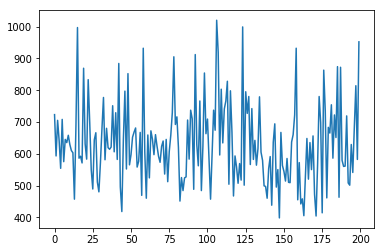

In [364]:
data_clustered.cluster_centers_, (data_clustered.counts_>0).sum()/N_clusters
plt.plot(data_clustered.counts_)

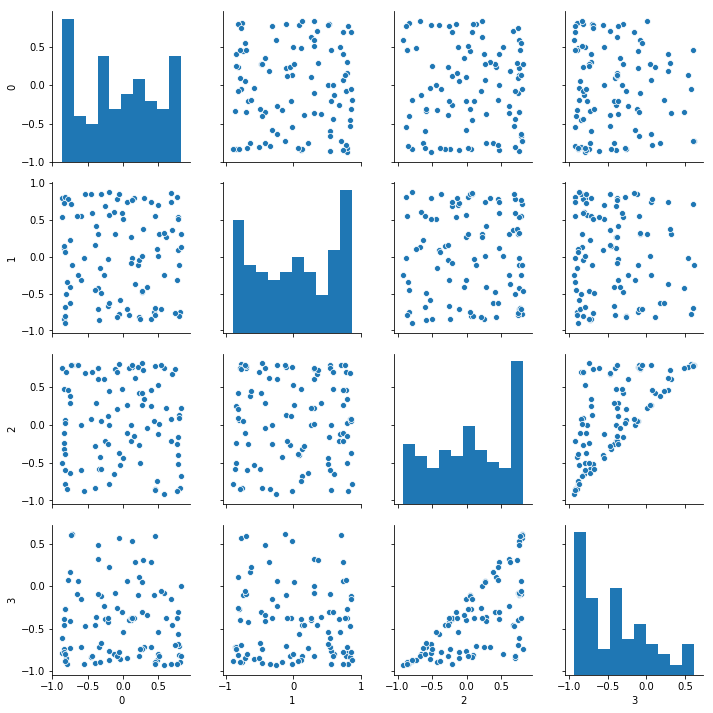

In [321]:
sb.pairplot(pd.DataFrame(data_clustered.cluster_centers_[0:100,]))

In [ ]:
####### Use cummulative reserve as target ##########

model = Sequential()
model.add(Dense(units = 3*n_h2, activation = 'relu',input_dim = n_in ))
model.add(Dense(units = n_h2, activation = 'linear'))

model.compile(optimizer='Adam',loss='mse',metrics= ['mae'])
model.build(input_shape= (5,1))
model.summary()

In [ ]:
rd = sobol_seq.i4_sobol_generate(2,1000)
plt.plot(rd[:,0],rd[:,1],'*')
plt.show()

In [ ]:
##### Simulate Data for Portfolio Clustering #####

N_contracts = 1000 # adjustable
age_low = 18
age_up = 67

data = np.zeros([5,N_contracts]).astype(int)

### Simulate ages of contract holders ###
sim1 = gamma.rvs(3,4,size=N_contracts)
data[0,:] = age_low +sim1/np.max(sim1)*(age_up-age_low)
data[0,:].astype(int)
plt.hist(data[0,:])
plt.show()

### simulate sums insured ###
data[1,:] = np.random.uniform(10000,200000,N_contracts)
plt.hist(data[1,:])
plt.show()

### simulate duration ###
data[2,:] = np.random.randint(5,40,size = (1,N_contracts))
plt.hist(data[2,:])
plt.show()

### simulate age of contract, i.e. introduce shifts in reserve profiles ###
sim3 = np.random.normal(7,4,N_contracts)
data[3,] = (abs(sim3.astype(int))+sim3.astype(int))/2
plt.hist(data[3,])
plt.show()

### simulate years of death ###
deaths = np.random.rand(N_contracts)
cum_probs_live = np.zeros([age_up-age_low+1,age_max-age_low])
range_age = np.array(range(age_low, age_up),ndmin = 2).T
range_time = np.array(range(age_max-age_low),ndmin= 2)
cum_probs_live = np.array(np.exp(-np.dot(A,range_time)-B/np.log(c)*c**range_age*(c**(range_time)-1)),ndmin = 2)
cum_probs_live[48,0:20]

for k in range(N_contracts):
    data[4,k] = (np.where(cum_probs_live[(data[0,k].astype(int)-age_low-1),:]<deaths[k]))[0][0]
    pass

# add age at entry and years of survival to obtain age of deatch
data[4,:] = data[4,:]+data[0,:]

plt.hist(data[4,:],bins=20,density=1)
plt.title('Distribution of ages of death for simulated data')
plt.show()

In [ ]:
import time
t_start = time.time()
time.sleep(5)
t_end = time.time()
t_end-t_start